In [1]:
from models import BiLSTM, BiRNN
import modal
import torch 
import lab
import numpy as np
import matplotlib.pyplot as plt
import torch 
import scipy
import pydvma as dvma
import torch.nn as nn
from tqdm import tqdm
import matplotlib.patches as patches
import scienceplots
import pints
import pints.plot
from numba import jit
import corner
import emcee
import sampler
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [2]:
plt.style.use('science')
plt.rcParams.update({"font.size":15})

In [3]:
%matplotlib inline

### Functions

In [4]:
class ModalSumDB(pints.ForwardModel):
    def __init__(self, param, phase_flag):
        super().__init__()
        self.dimension = len(param) - 1
        self.phase_flag = phase_flag

    # @jit(nopython=True)
    def simulate(self, thetas, w):
        tf = np.zeros_like(w, dtype=np.complex64)
        if self.phase_flag:
            n = len(thetas) // 4
            w_n, a_n, z_n, p_n = thetas[:n], thetas[n:2*n], thetas[2*n:3*n], thetas[3*n:4*n]
            for i in range(len(a_n)):
                tf += a_n[i] * 1j * w * np.exp(p_n[i] * 1j) / (w_n[i] ** 2 - w**2 + 2j * z_n[i] * w * w_n[i])
        else:
            n = len(thetas) // 3
            w_n, a_n, z_n = thetas[:n], thetas[n:2*n], thetas[2*n:3*n]
            for i in range(len(a_n)):
                tf += a_n[i] * 1j * w / (w_n[i] ** 2 - w**2 + 2j * z_n[i] * w * w_n[i])

        # tf[0] += 0.01 + 0.01j
        tf[0] = tf[1]
        tf_db = 20 * np.log10(np.sqrt(tf.real ** 2 + tf.imag ** 2))

        return tf_db

    def n_parameters(self):
        return self.dimension

In [5]:
class ModalSumMultiOut(pints.ForwardModel):
    def __init__(self, param):
        super().__init__()
        self.dimension = len(param) - 2

    # @jit(nopython=True)
    def simulate(self, thetas, w):
        n = (len(thetas) - 1) // 3
        w_n, a_n, z_n = thetas[:n], thetas[n:2*n], thetas[2*n:3*n]
        tf = np.zeros_like(w, dtype=np.complex64)
        for i in range(len(a_n)):
            tf += a_n[i] * 1j * w / (w_n[i] ** 2 - w**2 + 2j * z_n[i] * w * w_n[i])
        return modal.split_real_imag(tf)

    def n_parameters(self):
        return self.dimension

    def n_outputs(self):
        return 2

In [6]:
class Sampler:
    def __init__(self, model, raw_tf, w=None, prior="uniform"):
        """
        Initialize the Sampler class.

        Parameters
        ----------
        model : torch.nn.Module
            The trained model to be used for sampling.
        raw_tf : np.ndarray
            The raw transfer function to be used for sampling.
            Shape (n, ) where n is the number of frequency points.
            Each entry is a complex number.
        w : np.ndarray, optional
            The frequency points at which the transfer function is sampled.
            Shape (n, ) where n is the number of frequency points.
        """
        self.model = model
        self.raw_tf = raw_tf
        if w is None:
            self.w = np.linspace(0, 1, len(raw_tf))
            self.normalised_freq = True
        else:
            self.w = w
            self.normalised_freq = False
        # self.tf_db = modal.to_db(self.raw_tf) 
        self.tf_db = 20 * np.log10(np.sqrt(raw_tf.real ** 2 + raw_tf.imag ** 2))
        self.real_tf = np.real(self.raw_tf)
        self.run_flag = False

    def run_sampler(
        self,
        nwalkers: int = 100,
        nsteps: int = 1000,
        plot_predictions: bool = True,
        reparamaterize: bool = False,
        prior: str = "uniform",
        sampler: str = "emcee",
        pints_sampler = pints.EmceeHammerMCMC,
        phase: bool = False,
        sample_cutoff: int = -1,
        return_results: bool = False,
        multi_output: bool = False,
        max_opt_its: int = 8000,
    ) -> None:

        assert prior in [
            "uniform",
            "normal",
        ], "Prior type must be 'uniform' or 'normal'."
        assert sampler in [
            "emcee",
            "pcn",
            "pints",
        ], "Sampler type must be 'emcee' or 'pcn' or 'pints'."

        # assuming multiclass model
        raw_predictions = self.get_lab_predictions(plot_tf=plot_predictions)
        self.predictions = np.argmax(raw_predictions, axis=-1).reshape(-1)

        self.sample_cutoff = sample_cutoff
        self.predictions = self.predictions[:sample_cutoff]
        
        self.reparamaterize = reparamaterize
        self.prior_type = prior
        self.sampler_type = sampler
        self.phase_flag = phase
        
        log_prior = self.get_log_prior() # obtains self.mins and self.maxs
        # log_posterior = self.get_log_posterior(log_prior)
        self.log_prior = log_prior
        log_posterior = self.get_log_posterior()

        self.burned_flag = False
        self.labels = self._get_labels()

        if self.sampler_type == "emcee":
            p0 = np.random.uniform(self.mins, self.maxs, size=(nwalkers, self.ndim))
            # with Pool() as pool:
            self.sampler = emcee.EnsembleSampler(
                nwalkers,
                self.ndim,
                log_posterior,
                # pool=pool,
                # args=(self.w, self.raw_tf),
            )
            self.sampler.run_mcmc(p0, nsteps, progress=True)
            self.run_flag = True
            self.samples = self.sampler.get_chain()
            print(self.samples.shape)
            self.flat_samples_all = self.sampler.get_chain(flat=True)

        elif self.sampler_type == "pcn":
            mu = (self.mins + self.maxs) / 2
            s = np.maximum(self.maxs - mu, mu - self.mins)
            std = s / 2
            K = np.diag(std**2)  # Prior covariance
            self.samples = np.zeros((nsteps, nwalkers, self.ndim))
            for walker in tqdm(range(nwalkers)):
                p0 = np.random.uniform(self.mins, self.maxs, size=self.ndim)
                self.samples[:, walker, :], acc = self.pcn(p0, K, nsteps, 0.008)
            self.run_flag = True
            self.flat_samples_all = self.samples.reshape(-1, self.ndim)
            print(self.samples.shape, acc)
        
        elif self.sampler_type == "pints":
            self.mins[-1] = 0
            # self.maxs[-1] = 1
            # self.maxs[-1] = 5
            self.maxs[-1] = 5
            # self.mins = np.append(self.mins, 0)
            # self.maxs = np.append(self.maxs, 1)
            # self.mins = np.array([0.2, 0.4, 0.7, 0.5, 1, 0.5, 0, 0, 0, 0])
            # self.maxs = np.array([0.3, 0.6, 0.9, 1, 2, 1.5, 0.3, 0.3, 0.3, 1])

            # p0 = np.random.uniform(self.mins, self.maxs, size=(nwalkers, self.ndim))
            if multi_output:
                problem = pints.MultiOutputProblem(ModalSumMultiOut(self.mins), self.w, modal.split_real_imag(self.raw_tf))
            else:
                problem = pints.MultiOutputProblem(ModalSumDB(self.mins, self.phase_flag), self.w, self.tf_db) # Matching dB setting
                # problem = pints.SingleOutputProblem(ModalSumDB(self.mins), self.w, self.tf_db) # Matching dB setting
            log_likelihood = pints.GaussianLogLikelihood(problem)

            # Define boundaries for ML estimate
            wmin, amin, zmin = self.mins[:self.n_modes], self.mins[self.n_modes:2*self.n_modes], self.mins[2*self.n_modes:3*self.n_modes]
            wmax, amax, zmax = self.maxs[:self.n_modes], self.maxs[self.n_modes:2*self.n_modes], self.maxs[2*self.n_modes:3*self.n_modes]
            if not self.phase_flag:
                lb = np.concatenate((wmin / 1.2, -2*np.maximum(np.abs(amin),np.abs(amax)), [0]*self.n_modes, [0]))
                ub = np.concatenate((wmax * 1.2, 2*np.maximum(np.abs(amin),np.abs(amax)), [1.5]*self.n_modes, [10]))
            else: 
                lb = np.concatenate((wmin / 1.2, -2*np.maximum(np.abs(amin),np.abs(amax)), [0]*self.n_modes, [-np.pi/4]*self.n_modes, [0]))
                ub = np.concatenate((wmax * 1.2, 2*np.maximum(np.abs(amin),np.abs(amax)), [1.5]*self.n_modes, [np.pi/4]*self.n_modes, [10]))
            boundaries = pints.RectangularBoundaries(lb, ub)


            # Compute maximum likelihood estimate
            opt = pints.OptimisationController(log_likelihood, x0=np.random.uniform(self.mins, self.maxs), boundaries=boundaries)
            opt.set_max_iterations(max_opt_its)
            x0, _ = opt.run()
            # x0 = pints.optimise(log_likelihood, np.random.uniform(self.mins, self.maxs))[0]

            for i in range(len(x0)):
                # print(f"{self.mins[i]}, {x0[i]}, {self.maxs[i]}")
                if x0[i] > self.maxs[i]:
                    if np.sign(x0[i]) == 1:
                        self.maxs[i] = x0[i] * 2
                    else:
                        self.maxs[i] = x0[i] / 2
                elif x0[i] < self.mins[i]:
                    if np.sign(x0[i]) == 1:   
                        self.mins[i] = x0[i] / 2
                    else:
                        self.mins[i] = x0[i] * 2

            # if not self.phase_flag:
            #     n = len(x0) // 3
            #     w_n, a_n, z_n = x0[:n], x0[n:2*n], x0[2*n:3*n]
            #     for i, z in enumerate(z_n):
            #         if 
            # for i in range(len(x0)):
            #     print(f"{self.mins[i]}, {x0[i]}, {self.maxs[i]}")
            
            if self.prior_type == "uniform":
                log_prior = pints.UniformLogPrior(self.mins, self.maxs)
                
            elif self.prior_type == "normal":
                mu = (self.mins + self.maxs) / 2
                s = np.minimum(self.maxs - mu, mu - self.mins)
                std = s / 2 # 2 standard deviations
                cov = np.diag(std ** 2)
                log_prior = pints.MultivariateGaussianLogPrior(mu, cov)
            
            log_posterior = pints.LogPosterior(log_likelihood, log_prior)

            # Add noise to the maximum likelihood estimate
            # sigma = np.minimum(x0-self.mins, self.maxs-x0) / 2.0
            sigma = np.minimum(x0-self.mins, self.maxs-x0) / 4.0
            p0 = np.random.normal(loc=x0, scale=sigma, size=(nwalkers, len(x0)))
            p0 = np.clip(p0, self.mins, self.maxs)

            # Print log-likelihood for each initial point
            for i in range(nwalkers):
                # print(f"Log-likelihood for walker {i + 1}: {log_posterior(p0[i, :])}")
                while not np.isfinite(log_posterior(p0[i, :])):
                    p0[i, :] = np.random.normal(loc=x0, scale=sigma)     

            mcmc = pints.MCMCController(
                log_posterior, nwalkers, p0, method=pints_sampler
            )
            mcmc.set_max_iterations(nsteps)
            mcmc.set_log_to_screen(True)
            mcmc.set_log_interval(1000)
            print('Running...')
            self.samples = mcmc.run()
            self.samples = np.transpose(self.samples, (1, 0, 2))
            self.flat_samples_all = self.samples.reshape(-1, self.ndim)
            self.run_flag = True
            # pints.plot.trace(self.samples, parameter_names=self.labels)
            # plt.show()
            if return_results:
                results = pints.MCMCSummary(chains=self.samples, time=mcmc.time(), parameter_names=self.labels)
                print(results)

    def generate_samples(self, args):
        walker, nsteps, ndim, mins, maxs, K = args
        p0 = np.random.uniform(mins, maxs, size=ndim)
        samples, acc = self.pcn(p0, K, nsteps, 0.008)
        return samples, acc

    def pcn(self, theta0, K, n_iters, beta):
        """pCN MCMC method for sampling from pdf defined by log_prior and log_likelihood.
        Inputs:
            log_likelihood - log-likelihood function
            theta0 - initial sample
            K - prior covariance
            n_iters - number of samples
            beta - step-size parameter
        Returns:
            X - samples from target distribution
            acc/n_iters - the proportion of accepted samples"""
        X = []
        acc = 0
        u_prev = theta0
        N = theta0.shape[0]
        w = self.w
        tf = self.raw_tf
        ll_prev = self.log_likelihood(u_prev, w, tf)

        Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))

        for i in range(n_iters):

            # u_new = np.sqrt(1-beta**2) * u_prev + beta * np.random.multivariate_normal(np.zeros(N), K) # DONE: Propose new sample using pCN proposal
            u_new = np.sqrt(1 - beta**2) * u_prev + beta * Kc @ np.random.randn(
                N,
            )
            ll_new = self.log_likelihood(u_new, w, tf)

            log_alpha = min(
                ll_new - ll_prev, 0.0
            )  # DONE: Calculate pCN acceptance probability
            log_u = np.log(np.random.random())

            # Accept/Reject
            accept = (
                log_alpha >= log_u
            )  # DONE: Compare log_alpha and log_u to accept/reject sample (accept should be boolean)
            if accept:
                acc += 1
                X.append(u_new)
                u_prev = u_new
                ll_prev = ll_new
            else:
                X.append(u_prev)

        return np.array(X), acc / n_iters

    def get_samples(self) -> np.ndarray:
        """
        Getter for the samples from the sampler."""
        if self.run_flag:
            return self.samples
        else:
            raise ValueError("Sampler has not been run yet.")

    def plot_hist(self, num_modes, figsize=(15, 10), name=None):

        fig, axs = plt.subplots(num_modes, 3, figsize=figsize, tight_layout=True)
        for i in range(num_modes):
            axs[0, i].hist(self.flat_samples[:, i], bins=100, color='k', histtype='step')
            axs[1, i].hist(self.flat_samples[:, i + self.n_modes], bins=100, color='k', histtype='step')
            axs[2, i].hist(self.flat_samples[:, i + 2*self.n_modes], bins=100, color='k', histtype='step')
            axs[0, i].yaxis.set_major_formatter(plt.NullFormatter()) 
            axs[1, i].yaxis.set_major_formatter(plt.NullFormatter()) 
            axs[2, i].yaxis.set_major_formatter(plt.NullFormatter())
            q1 = corner.quantile(self.flat_samples[:, i], [0.16, 0.5, 0.84])
            q2 = corner.quantile(self.flat_samples[:, i + self.n_modes], [0.16, 0.5, 0.84])
            q3 = corner.quantile(self.flat_samples[:, i + 2*self.n_modes], [0.16, 0.5, 0.84])
            axs[0, i].set_title(fr'$\omega_{i+1} = {q1[1]:.2f}^{{+{q1[2]-q1[1]:.2f}}}_{{-{q1[1]-q1[0]:.2f}}}$')
            axs[1, i].set_title(fr'$a_{i+1} = {q2[1]:.2f}^{{+{q2[2]-q2[1]:.3f}}}_{{-{q2[1]-q2[0]:.3f}}}$')
            axs[2, i].set_title(fr'$\zeta_{i+1} = {q3[1]:.4f}^{{+{q3[2]-q3[1]:.4f}}}_{{-{q3[1]-q3[0]:.4f}}}$')
        if name is not None:
            plt.savefig(f"./Figs/{name}.pdf")   
        plt.show()

        if self.run_flag:
            fig, axs = plt.subplots(num_modes, 3, figsize=figsize)
            for i in range(num_modes):
                axs[i, 0].hist(self.samples[:, :, i], bins=100, color="black", alpha=0.3)
                axs[i, 0].set_title(f"Mode {i+1} - $\omega$")
                axs[i, 1].hist(self.samples[:, :, i+num_modes], bins=100, color="black", alpha=0.3)
                axs[i, 1].set_title(f"Mode {i+1} - $a$")
                axs[i, 2].hist(self.samples[:, :, i+2*num_modes], bins=100, color="black", alpha=0.3)
                axs[i, 2].set_title(f"Mode {i+1} - $\zeta$")
            plt.show()
        else:
            raise ValueError("Sampler has not been run yet.")


    def plot_state_evolution(self, mode_num=None, figsize=None,ypos=-0.1, name=None, mode_truths=None) -> None:
        if self.run_flag:
            if mode_num:
                if isinstance(mode_num, int):
                    if figsize is None:
                        figsize = (6,3)
                    if self.phase_flag:
                        indices = [mode_num-1, mode_num-1+self.n_modes, mode_num-1+2*self.n_modes, mode_num-1+3*self.n_modes]
                        labels = [rf"$\omega_{mode_num}$", rf"$a_{mode_num}$", rf"$\zeta_{mode_num}$", rf"$\phi_{mode_num}$"]
                        max_range = 4
                    else:
                        labels = [rf"$\omega_{mode_num}$", rf"$a_{mode_num}$", rf"$\zeta_{mode_num}$"]
                        indices = [mode_num-1, mode_num-1+self.n_modes, mode_num-1+2*self.n_modes]
                        max_range = 3
                    fig, axs = plt.subplots(max_range, figsize=figsize, sharex=True)
                    for i in range(max_range):
                        ax = axs[i]
                        ax.plot(self.samples[:, :, indices[i]], "k", alpha=0.3)
                        ax.set_ylabel(labels[i])
                        if mode_truths:
                            ax.axhline(mode_truths[i], color="r", linestyle="--")
                        ax.yaxis.set_label_coords(ypos, 0.5)
                    axs[-1].set_xlabel("Iteration")
                    # plt.show()
            else:
                if figsize is None:
                    figsize = (10, self.ndim)
                if self.sampler_type == "emcee":
                    max_range = self.ndim-1
                else:
                    max_range = self.ndim
                fig, axes = plt.subplots(max_range, figsize=figsize, sharex=True) #, gridspec_kw={'left': 0.2, 'bottom': 0.2}
                # fig.subplots_adjust(left=0.2, bottom=0.2)
                # fig.tight_layout(rect=(0.2,0.2,1,1))
                for i in range(max_range):
                    ax = axes[i]
                    ax.plot(self.samples[:, :, i], "k", alpha=0.3)
                    ax.set_xlim(0, len(self.samples))
                    ax.set_ylabel(self.labels[i])
                    ax.yaxis.set_label_coords(ypos, 0.5)
                axes[-1].set_xlabel("Iteration")
                # plt.subplots_adjust(left=0.1, bottom=0.3, right=1, top=0.7, wspace=0, hspace=0.05)
            if name:
                plt.savefig(f"./Figs/{name}.pdf")
            plt.show()
        else:
            raise ValueError("Sampler has not been run yet.")

    def burn_in(self, nburn: int) -> None:
        if self.run_flag:
            if self.sampler_type == "emcee":
                self.flat_samples = self.sampler.get_chain(discard=nburn, flat=True)
                self.log_probs = self.sampler.get_log_prob(discard=nburn, flat=True)
                self.burned_flag = True
                print(self.flat_samples.shape)
            else:
                self.samples = self.samples[nburn:, :, :]
                self.flat_samples = self.samples.reshape(-1, self.ndim)
                # self.flat_samples = self.samples[nburn:, :, :].reshape(-1, self.ndim)
                self.burned_flag = True

        else:
            raise ValueError("Sampler has not been run yet.")

    def plot_histograms(self) -> None:
        if self.run_flag:
            pints.plot.histogram(self.samples, parameter_names=self.labels)

    def plot_corner(self, truths=None, mode_num=None, figsize=(6,6), tight=True, lpad=1, name=None, overlay=False) -> None:
        if self.burned_flag:
            flat_samples = self.flat_samples
        else:
            flat_samples = self.flat_samples_all

        if self.run_flag:
            if overlay:
                indices_0 = [0, self.n_modes, 2*self.n_modes]
                data_to_plot_0 = flat_samples[:, indices_0]
                labels = [rf"$\omega_{1}$", rf"$a_{1}$", rf"$\zeta_{1}$"]
                if truths is not None:
                    selected_truths = [truths[i] for i in indices_0]
                else:
                    selected_truths = None
                plt.figure(tight_layout=tight, figsize=figsize)
                fig = corner.corner(
                            data=data_to_plot_0,
                            labels=labels,
                            truths=selected_truths,
                            quantiles=[0.16, 0.5, 0.84],
                            show_titles=True,
                            title_fmt=".4f",
                            title_kwargs={"fontsize": 16},
                            label_kwargs={"fontsize": 16, "labelpad": lpad},
                            truth_color="r",
                            plot_contours=True,
                        )
                colors = ["r", "b"]
                for i in range(1, self.n_modes+1):
                    indices = [i, i+self.n_modes, i+2*self.n_modes]
                    data_to_plot = flat_samples[:, indices]
                    labels = [rf"$\omega_{i}$", rf"$a_{i}$", rf"$\zeta_{i}$"]
                    corner.corner(
                        data=data_to_plot,
                        labels=labels,
                        truths=selected_truths,
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True,
                        title_fmt=".4f",
                        title_kwargs={"fontsize": 16},
                        label_kwargs={"fontsize": 16, "labelpad": lpad},
                        truth_color="r",
                        plot_contours=True,
                        fig=fig,
                        color = colors[i%2]
                    )
                if name:
                    plt.savefig(f"./Figs/{name}_corner_overlay.pdf")
                plt.show()

            if mode_num:
                if isinstance(mode_num, list):
                    for mode in mode_num:
                        mode = int(mode)
                        indices = [mode-1, mode-1+self.n_modes, mode-1+2*self.n_modes]
                        if truths is not None:
                            selected_truths = [truths[i] for i in indices]
                        else:
                            selected_truths = None
                        
                        data_to_plot = flat_samples[:, indices]
                        labels = [rf"$\omega_{mode}$", rf"$a_{mode}$", rf"$\zeta_{mode}$"]
                        plt.figure(tight_layout=tight, figsize=figsize)
                        fig = corner.corner(
                            data=data_to_plot,
                            labels=labels,
                            truths=selected_truths,
                            quantiles=[0.16, 0.5, 0.84],
                            show_titles=True,
                            title_fmt=".4f",
                            title_kwargs={"fontsize": 16},
                            label_kwargs={"fontsize": 16, "labelpad": lpad},
                            truth_color="r",
                            plot_contours=True,
                        )
                        if name:
                            plt.savefig(f"./Figs/{name}_corner_{mode}.pdf")
                        plt.show()
                elif isinstance(mode_num, int):
                    if self.phase_flag:
                        indices = [mode_num-1, mode_num-1+self.n_modes, mode_num-1+2*self.n_modes, mode_num-1+3*self.n_modes]
                        labels = [rf"$\omega_{mode_num}$", rf"$a_{mode_num}$", rf"$\zeta_{mode_num}$", rf"$\phi_{mode_num}$"]
                    else:
                        indices = [mode_num-1, mode_num-1+self.n_modes, mode_num-1+2*self.n_modes]
                        labels = [rf"$\omega_{mode_num}$", rf"$a_{mode_num}$", rf"$\zeta_{mode_num}$"]

                    if truths is not None:
                        selected_truths = [truths[i] for i in indices]
                    else:
                        selected_truths = None

                    data_to_plot = flat_samples[:, indices]

                    fig = corner.corner(
                        data=data_to_plot,
                        labels=labels,
                        truths=selected_truths,
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True,
                        title_fmt=".4f",
                        title_kwargs={"fontsize": 21},
                        label_kwargs={"fontsize": 21, "labelpad": lpad},
                        hist2d_kwargs={"data_kwargs": {"alpha": 0.1}},
                        truth_color="r",
                        plot_contours=True,
                    )
                    if name:
                        plt.savefig(f"./Figs/{name}_corner_{mode_num}.pdf")
                    plt.show()
            else:
                plt.figure(tight_layout=tight)
                fig = corner.corner(
                    data=flat_samples,
                    labels=self.labels,
                    truths=truths,
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_fmt=".4f",
                    title_kwargs={"fontsize": 14},
                    truth_color="r",
                    plot_contours=True,
                )
                plt.show()
        else:
            raise ValueError("Sampler has not been run yet.")

    def plot_posterior_samples(
        self,
        n_samples: int = 100,
        posterior_mean: bool = False,
        posterior_error: bool = False,
        figsize=(7,4),
        name=None,
        ws=None,
        y=None,
        markevery=5,
        tf_alpha=1.0,
        zoomed=False,
        xlims=None, # x and y lims for zoomed box
        ylims=None,
    ) -> None:
        """
        Plot the posterior samples of the transfer function, alongside
        the original transfer function.

        Parameters
        ----------
        n_samples : int, optional
            Number of samples to plot.
        posterior_mean : bool, optional
            If True, plot the posterior mean of the transfer function.
        posterior_error : bool, optional
            If True, plot += 1 standard deviation error bars around the posterior mean.
        """
        if self.burned_flag:
            flat_samples = self.flat_samples
            # log_probs = self.log_probs
        else:
            flat_samples = self.flat_samples_all
            # log_probs = self.get_log_probs()
        # flat_samples = flat_samples[
        #     log_probs > 0
        # ]  # only consider samples with positive log probs (converged)
        inds = np.random.randint(len(flat_samples), size=n_samples)
        n = len(self.mins - 1) // 3
        fig, ax = plt.subplots(figsize=figsize)
        # plt.plot(self.w[:self.sample_cutoff], self.tf_db[:self.sample_cutoff], color="blue", label="True TF")

        if zoomed:
            axins = zoomed_inset_axes(ax, zoom=2, loc='lower right') # loc=4

        for ind in inds:
            sample = flat_samples[ind]
            if self.reparamaterize:
                sample = self._convert_theta(sample)
            ax.plot(self.w[:self.sample_cutoff], ModalSumDB(self.mins, self.phase_flag).simulate(sample, self.w[:self.sample_cutoff]), color="red", alpha=0.1)
            if zoomed:
                axins.plot(self.w[:self.sample_cutoff], ModalSumDB(self.mins, self.phase_flag).simulate(sample, self.w[:self.sample_cutoff]), color="red", alpha=0.1)

        ax.plot(self.w[:self.sample_cutoff], self.tf_db[:self.sample_cutoff], color="blue", label="True TF", marker='o',ms=2, linewidth=0.75, markevery=markevery, alpha=tf_alpha)   
        if zoomed:
            axins.plot(self.w[:self.sample_cutoff], self.tf_db[:self.sample_cutoff], color="blue", label="True TF", marker='o',ms=2, linewidth=0.5, markevery=markevery, alpha=tf_alpha)   

        if y is not None:
            mask = np.zeros_like(self.w)
            mask[y == 1] = 1
            ax.imshow(mask.reshape(1, -1), aspect='auto', extent=[0, 1, ax.get_ylim()[0], ax.get_ylim()[1]], cmap='Greys', alpha=0.1)

        if ws is not None:
            for w_n in ws:
                    ax.axvline(w_n, c='black', linestyle='--', alpha=0.5)

        if zoomed:
            axins.set_xlim(xlims[0], xlims[1])  # Limit the x-axis range for the inset
            axins.set_ylim(ylims[0], ylims[1])  # Limit the y-axis range for the inset

            # Hide ticks on inset
            axins.xaxis.set_visible(False)
            axins.yaxis.set_visible(False)

            # Draw lines to indicate the zoomed area
            mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")


        if posterior_mean:
            mean = np.mean(flat_samples, axis=0)
            if self.reparamaterize:
                mean = self._convert_theta(mean)
            mean_tf = modal.modal_sum_fast(
                self.w, mean[n : 2 * n], mean[2 * n : 3 * n], mean[:n]
            )
            if posterior_error:
                plt.clf()  # clear the figure
                std = np.std(flat_samples, axis=0)
                if self.reparamaterize:
                    std = self._convert_theta(std)
                min_tf = modal.modal_sum_fast(
                    self.w,
                    (mean - std)[n : 2 * n],
                    (mean - std)[2 * n : 3 * n],
                    (mean - std)[:n],
                )
                max_tf = modal.modal_sum_fast(
                    self.w,
                    (mean + std)[n : 2 * n],
                    (mean + std)[2 * n : 3 * n],
                    (mean + std)[:n],
                )
                plt.fill_between(
                    self.w,
                    modal.to_db(min_tf),
                    modal.to_db(max_tf),
                    color="black",
                    alpha=0.2,
                    label=r"$\pm 1$ Standard deviation",
                )
                plt.plot(
                    self.w, modal.to_db(mean_tf), color="black", label="Posterior Mean"
                )
                plt.plot(self.w, self.tf_db, color="blue", label="True TF", alpha=0.5)
            else:
                plt.plot(
                    self.w, modal.to_db(mean_tf), color="green", label="Posterior Mean"
                )
        # plt.legend()
        if self.normalised_freq:
            ax.set_xlabel("Normalised Frequency")
        else:
            ax.set_xlabel("Frequency (rad/s)")
        ax.set_ylabel("Magnitude (dB)")
        if name:
            plt.savefig(f"./Figs/{name}.pdf")
        

        plt.show()

    def get_log_prior(self) -> callable:
        frequency_groups, tf_groups, real_tf_groups = self._extract_groups()
        priors, self.mins, self.maxs = self._generate_prior_groups(
            frequency_groups, tf_groups, real_tf_groups
        )
        mins = self.mins
        maxs = self.maxs
        self.ndim = len(self.mins)
        self.n_modes = (self.ndim - 1) // 4 if self.phase_flag else (self.ndim - 1) // 3        

        if self.prior_type == "uniform":

            @jit(nopython=True)
            def log_prior(theta) -> float:
                if np.all(mins < theta) and np.all(theta < maxs):
                    return 0.0
                else:
                    return -np.inf

        elif self.prior_type == "normal":
            mu = (mins + maxs) / 2
            # s = np.maximum(maxs - mu, mu - mins)
            s = np.minimum(maxs - mu, mu - mins)
            std = s / 2  # 2 standard deviations

            @jit(nopython=True)
            def log_prior(theta) -> float:
                diff = theta - mu
                return -0.5 * np.dot(diff, 1 / std**2 * diff)
                # return -0.5 * diff.T @ (1 / std ** 2) @ diff

        return log_prior

    @staticmethod
    @jit(nopython=True)
    def log_likelihood(theta, w, tf) -> float:
        var = np.exp(theta[-1]) ** 2
        n = (len(theta) - 1) // 3
        # model = modal.modal_sum(
        #     w, theta[n : 2 * n], theta[2 * n : 3 * n], theta[:n], logsigma=None
        # )[0]
        model = modal.modal_sum_fast(
            w, theta[n : 2 * n], theta[2 * n : 3 * n], theta[:n]
        )
        # tf_db = 20 * np.log10(np.sqrt(tf.real ** 2 + tf.imag ** 2))
        # model_db = 20 * np.log10(np.sqrt(model.real ** 2 + model.imag ** 2))
        # diff = tf_db - model_db
        # squared_norm = np.sum(diff ** 2)
        # return -len(w) * np.log(2 * np.pi * var) - squared_norm / (2 * var)

        diff = modal.split_real_imag(tf - model)
        # squared_norm = np.sum(np.linalg.norm(diff, axis=1) ** 2)
        squared_norm = np.sum(diff.real**2 + diff.imag**2)
        return -len(w) * np.log(2 * np.pi * var) - squared_norm / (2 * var)

    def get_acceptance_fraction(self) -> float:
        if self.run_flag:
            return np.mean(self.sampler.acceptance_fraction)
        else:
            raise ValueError("Sampler has not been run yet.")

    def get_log_probs(self):
        if self.run_flag:
            return self.sampler.get_log_prob()
        else:
            raise ValueError("Sampler has not been run yet.")

    def log_posterior(self, theta) -> float:
        # w = self.w
        # tf = self.raw_tf
        lp = self.log_prior(theta)
        if lp == -np.inf:
            return -np.inf
        if self.reparamaterize:
            theta = self._convert_theta(theta)
        return lp + self.log_likelihood(theta, self.w, self.raw_tf)

    def get_log_posterior(self) -> callable:
        return self.log_posterior

    # def get_log_posterior(self, log_prior: callable) -> callable:
    #     def log_posterior(theta, w, tf) -> float:
    #         lp = log_prior(theta)
    #         if lp == -np.inf:
    #             return -np.inf
    #         return lp + self.log_likelihood(theta, w, tf)

    #     return log_posterior

    def _get_labels(self) -> list[str]:

        n = self.n_modes
        omega_labels = [rf"$\omega_{i}$" for i in range(1, n + 1)]
        if self.reparamaterize:
            a_labels = [rf"$a_{i}/(2\zeta_{i}\omega_{i})$" for i in range(1, n + 1)]
        else:
            a_labels = [fr"$a_{i}$" for i in range(1, n + 1)]
        zeta_labels = [fr"$\zeta_{i}$" for i in range(1, n + 1)]
        phase_lables = [fr"$p_{i}$" for i in range(1, n + 1)]
        if self.sampler_type == "pints":
            if self.phase_flag:
                labels = omega_labels + a_labels + zeta_labels + phase_lables + [r"$\sigma$"]
            else:
                labels = omega_labels + a_labels + zeta_labels + [r"$\sigma$"]
        else:
            labels = omega_labels + a_labels + zeta_labels + [r"$\log(\sigma)$"]
        return labels

    def _extract_groups(self):
        """
        Extract the predicted frequency groups and their corresponding transfer function values.
        """
        frequency_groups = []
        tf_groups = []
        real_tf_groups = []
        group_length = 0

        for i, prediction in enumerate(self.predictions):
            if prediction == 1 or prediction == 2:  # TODO: fix this
                group_length += 1
            elif group_length > 0: # changed 0 -> 1
                frequency_groups.append(self.w[i - group_length : i])
                tf_groups.append(self.tf_db[i - group_length : i])
                real_tf_groups.append(self.real_tf[i - group_length : i])
                group_length = 0
        # If the last element is part of a group, add it to the list
        if group_length > 0:
            frequency_groups.append(self.w[-group_length:])
            tf_groups.append(self.tf_db[-group_length:])
            real_tf_groups.append(self.real_tf[-group_length:])
        return frequency_groups, tf_groups, real_tf_groups

    def _generate_prior_groups(self, frequency_groups, tf_groups, real_tf_groups):
        """
        Use extracted frequency groups and their corresponding transfer function values to generate
        priors for each group (each mode).

        frequency_groups : list
            List of groups of frequency groups (natural frequency ranges).
        tf_groups : list
            List of groups of transfer function (in dB) values.
        real_tf_groups : list
            List of groups of real part of transfer function.
        """
        priors = []
        min_ws, max_ws = [], []
        min_as, max_as = [], []
        min_zs, max_zs = [], []
        for freq_group, tf_group, real_tf_group in zip(
            frequency_groups, tf_groups, real_tf_groups
        ):
            min_tf = np.min(tf_group)
            max_tf = np.max(tf_group)

            zeta = (freq_group[-1] - freq_group[0]) / (freq_group[-1] + freq_group[0])

            if self.reparamaterize:
                # parameters are now w_n, a_n / (2 * z_n * w_n), z_n
                # t2 is the second parameter
                zeta_min = 1e-4
                zeta_max = 0.8
                t2_min = 10 ** (min_tf / 20)
                t2_max = 10 ** (max_tf / 20)
                sign = np.sign(real_tf_group[np.argmax(np.abs(real_tf_group))])
                a_min, a_max = sign * t2_min, sign * t2_max
            else:
                # zeta_min = zeta / 2
                # zeta_max = zeta * 2
                zeta_min = zeta / 1.5
                zeta_max = zeta * 1.5
                # minimum and maximum permissible values for zeta
                if zeta_max > 0.8:
                    zeta_max = 0.8
                if zeta_min < 1e-4:
                    zeta_min = 1e-4
                
                if zeta_max < zeta_min:
                    zeta_max = 0.8
                

                if self.prior_type == "uniform":
                    scale_factor = 1
                elif self.prior_type == "normal":
                    scale_factor = 0.7
                # TODO: investigate scale factors
                a_min = 2 * zeta_min * freq_group[0] * 10 ** (min_tf / 20)
                a_max = 2 * zeta_max * freq_group[-1] * 10 ** (max_tf / 20)
                # Calculate sign of a_n using sign of real part of transfer function
                # sign = np.sign(real_tf_group[np.argmax(tf_group)])

                # pos_count = np.sum(real_tf_group > 0)
                # neg_count = np.sum(real_tf_group < 0)
                # sign = 1 if pos_count > neg_count else -1

                # sign as sign of maximum real part of transfer function in group
                sign = np.sign(real_tf_group[np.argmax(np.abs(real_tf_group))])

                if a_max < 3:
                # if a_max < 1:
                    # include +ve and -ve values of a if a_max is less than 2
                    a_max *= scale_factor
                    a_min = -a_max
                elif sign == -1:
                    # swap a_min and a_max
                    temp = a_min
                    a_min = -1 * a_max
                    a_max = -1 * temp

                a_min *= scale_factor
                a_max *= scale_factor

                if a_max > 20:
                    a_max = 20
                if a_min < -20:
                    a_min = -20

            if a_min == 0 or a_max == 0:
                a_min = -0.1
                a_max = 0.1

            priors.append(
                [
                    freq_group[0],
                    freq_group[-1],
                    a_min,
                    a_max,
                    zeta_min,
                    zeta_max,
                ]
            )
            min_ws.append(freq_group[0] * 0.95) # CHANGED
            max_ws.append(freq_group[-1] * 1.05) # CHANGED
            min_as.append(a_min)
            max_as.append(a_max)
            min_zs.append(zeta_min)
            max_zs.append(zeta_max)

        sigma_min = [-5]
        sigma_max = [-1]

        if self.phase_flag:
            p_min = [-np.pi/4] * int(len(min_ws))
            p_max = [np.pi/4] * int(len(min_ws))
            mins = np.append(np.array([min_ws, min_as, min_zs, p_min]).flatten(), sigma_min)
            maxs = np.append(np.array([max_ws, max_as, max_zs, p_max]).flatten(), sigma_max)
        else:
            mins = np.append(np.array([min_ws, min_as, min_zs]).flatten(), sigma_min)
            maxs = np.append(np.array([max_ws, max_as, max_zs]).flatten(), sigma_max)

        print(mins)
        print(maxs)

        return priors, mins, maxs

    def get_lab_predictions(self, plot_tf=False):
        """
        Get the lab predictions for the given transfer function.

        Parameters
        ----------
        plot_tf : bool, optional
            If True, plot the transfer function.

        Returns
        -------
        np.ndarray
            The raw lab predictions for the given transfer function.
            Shape (n, 3) where n is the number of frequency points.

        """
        return lab.lab_predictions(
            model=self.model,
            tf_arr=self.raw_tf,
            multiclass=True,
            extended=True,
            w=self.w,
            max_norm=True,
            plot_tf=plot_tf,
        )

    @staticmethod
    @jit(nopython=True)
    def _convert_theta(theta):
        """
        Convert reparameterised theta values to the original parameter space.
        (w_n, a_n / (2 * z_n * w_n), z_n, logsigma) -> (w_n, a_n, z_n, logsigma)
        """
        theta_new = np.copy(theta)
        n = (len(theta) - 1) // 3
        theta_new[n : 2 * n] = theta[n : 2 * n] * 2 * theta[:n] * theta[2 * n : 3 * n]
        return theta_new


In [7]:
model = torch.load('norm_95_max(28.02).pth')

In [32]:
def plot_tf(tf, y, todb=True, ws = None, figsize=(8,6), w=None, model=None,X=None, name=None):
    """Plot transfer function and show training labels and mode frequencies."""
    fig, ax = plt.subplots(figsize=figsize)
    if w is None:
        w = np.linspace(0, 1, len(y))
    else:
        w = w

    mask = np.zeros_like(w)
    mask[y == 1] = 1
    mask[y == 2] = 1
    if todb:
        tf_db = modal.to_db(tf)
        # ax.scatter(w[y == 1], modal.to_db(tf)[y == 1], c='red', marker='o', label=r'Training Labels $(t_m = 1)$')
        ax.plot(w, tf_db, label = 'Transfer Function', c='blue', alpha=0.7)

    ax.imshow(mask.reshape(1, -1), aspect='auto', extent=[0, 1, ax.get_ylim()[0], ax.get_ylim()[1]], cmap='Greys', alpha=0.1)

    if ws is not None:
        for w_n in ws:
                ax.axvline(w_n, c='black', linestyle='--', alpha=0.5)
    
    if w is not None:
        ax.set_xlabel('Frequency (rad/s)')
    else:
        ax.set_xlabel('Normalised Frequency')
    if todb:
        ax.set_ylabel('Magnitude (dB)')
    else:
        ax.set_ylabel('Magnitude')

    if model is not None and X is not None:
        tf_tensor = torch.from_numpy(X).to(torch.float32)
        model.eval()
        output = model(tf_tensor)
        test_op = np.array(output.detach().numpy())
        predicted = np.argmax(test_op, axis=-1).reshape(-1)

        mask = np.zeros_like(w)
        mask[predicted.reshape(-1) == 1] = 1
        mask[predicted.reshape(-1) == 2] = 1

        segment_start = None
        for i in range(len(w)):
            if predicted[i] == 1:
                if segment_start is None:
                    segment_start = i
            elif segment_start is not None:
                if i == segment_start + 1:
                    ax.scatter(w[segment_start], tf_db[segment_start], c='red',alpha=0.7, s=50)
                ax.plot(w[segment_start:i], tf_db[segment_start:i], c="red", alpha=0.7, linewidth=5, label='Predicted=1')
                segment_start = None
        if segment_start is not None:
            ax.plot(w[segment_start:i], tf_db[segment_start:i], c="red", alpha=0.7, linewidth=5)
    # legend_elements = []
    # legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Training Labels $(t_m = 1)$')]
    ax.set_xlim(-50,)
    if name is not None:
        plt.savefig(f"./Figs/{name}.pdf")
    plt.show()
    return fig, ax

In [9]:
def generate_dat_extended(num_data, num_w_points, sigma_max = 0.15, max_modes = 7,
                multiclass = False, normalise = None, neg_an=False, logmag=False, scaled_logmag=False, a_max=2.0, method =1, norm_95=False, w_n=None):
    """Generate num_data training examples with num_w_points frequency points.
    Pass normalisation function as a parameter. Include phase and magnintude 
    information in the output.
    X: (num_data, num_w_points, 4)
    Y: (num_data, num_w_points)
    ws: (num_data, max_modes)
    zs: (num_data, max_modes)"""
    X = []
    Y = []
    ws = []
    zs = []
    a_s = []
    w = np.linspace(0, 1, num_w_points)
    for i in range(num_data):
        num_modes = np.random.randint(0, max_modes + 1)
        if w_n is not None:
            num_modes = len(w_n)
        else:
            w_n = np.random.uniform(0, 1, num_modes)
        
        if neg_an:
            if method == 1:
                a_n = np.random.uniform(-a_max, a_max, num_modes)
            elif method == 2:
                a_max=2.5
                mag = np.random.uniform(-a_max, a_max, num_modes)
                phase = np.random.normal(0, np.pi / 8, num_modes)
                a_n = mag * np.exp(1j * phase)  # combine mag and phase to make a complex num
        else:
            a_n = np.random.uniform(1, 2, num_modes)
        if method == 1:
            z_n = np.random.uniform(0.01, 0.20, num_modes)
        elif method == 2:
            z_n = 10 ** (np.random.uniform(-3, -0.7, num_modes)) # log-uniform sampling of z_n
            # z_n = np.random.uniform(0.001, 0.20, num_modes)
        # sigma = np.random.uniform(0.0001, sigma_max)

        # sigma = np.random.uniform(np.log(8*1e-2), sigma_max)
        # sigma = np.random.uniform(np.log(1e-1), sigma_max)
        sigma = np.random.uniform(np.log(3e-1), 0.2)

        out, y = modal.modal_sum(w, a_n, z_n, w_n, sigma, multiclass)

        if normalise is not None:
            out = normalise(out)

        real_imag = modal.split_real_imag(out)
        phase = np.arctan(np.imag(out)/np.real(out))
        mag = np.abs(out)

        # phase = np.mod(phase, 2*np.pi)
        if norm_95 is True:
            max_mag = np.max(mag)
            mag = mag / (0.95 * max_mag)
            real_imag = real_imag / (0.95 * max_mag)

        if logmag is True:
            logmagnitude = np.log10(mag)
            if scaled_logmag is True:
                logmagnitude = (logmagnitude - np.mean(logmagnitude)) / np.std(logmagnitude)
            extended_op = np.concatenate((real_imag, phase.reshape(-1,1), mag.reshape(-1,1), logmagnitude.reshape(-1,1)), axis=1)
        else:
            extended_op = np.concatenate((real_imag, phase.reshape(-1,1), mag.reshape(-1,1)), axis=1)
        ws.append(w_n)
        zs.append(z_n)
        a_s.append(a_n)
        X.append(extended_op)
        Y.append(y)
    return np.array(X), np.array(Y), ws, zs, a_s

### Test example

In [345]:
w = np.linspace(0, 1,200)
w_n = [0.25, 0.5, 0.8]
a_n = [0.7, 1.5, 1.0]
z_n = [0.1, 0.15, 0.1]
logsigma = np.log(0.15)
theta = np.append(np.array([w_n, a_n, z_n]).flatten(), logsigma)

In [388]:
tf, y = modal.modal_sum(w, a_n, z_n, w_n, logsigma=logsigma)

AttributeError: Line2D.set() got an unexpected keyword argument 'figsize'

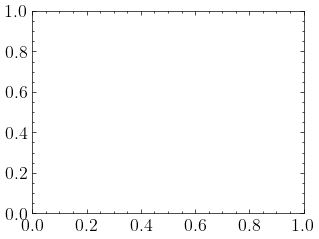

In [116]:
plt.plot(w, modal.to_db(tf))

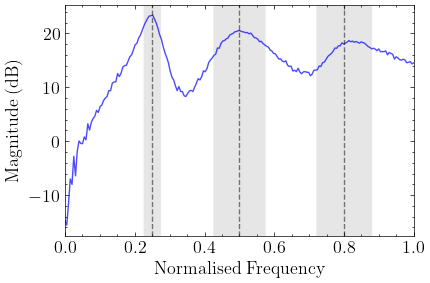

(<Figure size 450x300 with 1 Axes>,
 <Axes: xlabel='Normalised Frequency', ylabel='Magnitude (dB)'>)

In [347]:
plot_tf(tf,y,ws=w_n, figsize=(4.5, 3))

In [243]:
print(tf.shape)

(200,)


### Preliminary Testing

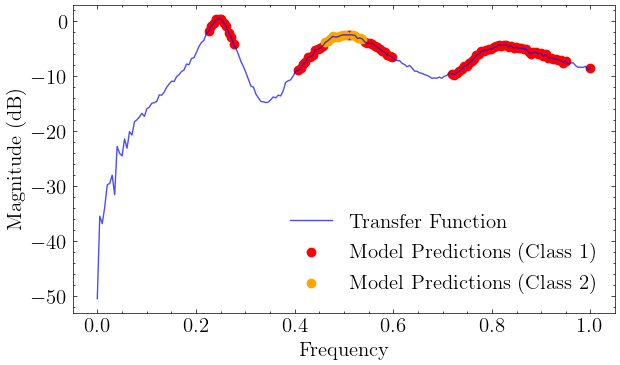

[ 0.21482412  0.38668342  0.68266332 -1.22666004  0.51795595  0.61044685
  0.06666667  0.12666667  0.09236948 -5.        ]
[ 0.29020101  0.62788945  0.99723618  1.22666004  3.59917923  3.38195161
  0.15        0.285       0.20783133 -1.        ]


100%|██████████| 400/400 [00:01<00:00, 377.62it/s]

(400, 500, 10)


In [530]:
s = Sampler(model,tf, w=None)
s.run_sampler(nwalkers=500, nsteps=400, sampler="emcee", return_results=True, phase=False, max_opt_its=200, multi_output=False)

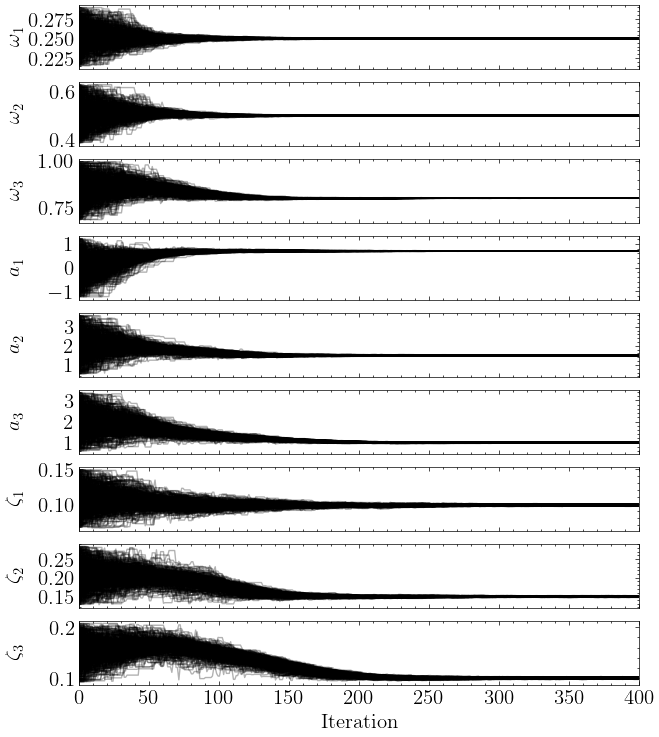

In [532]:
s.plot_state_evolution(figsize=(8,10),ypos=-0.1, name='test_traces')

In [536]:
s.burn_in(200)

(100000, 10)


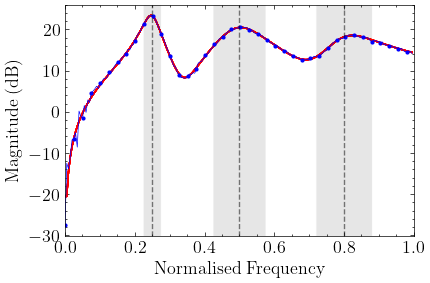

In [442]:
s.plot_posterior_samples(figsize=(4.5,3), ws=w_n, y=y, name='burn_in')

In [43]:
fig = plt.figure()
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color='black', label='Transfer Function'))
legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mode Frequency'))
rect = patches.Rectangle((0, 0), 1, 1, facecolor='#fb9a99', edgecolor='none', alpha=0.5, label='Training Labels (Class 1)')
legend_elements.append(rect)
rect = patches.Rectangle((0, 0), 1, 1, facecolor='#a6cee3', edgecolor='none', alpha=0.5, label='Training Labels (Class 2)')
legend_elements.append(rect)

legend = fig.legend(handles=legend_elements,
            # loc='upper center', 
        #    bbox_to_anchor=(0.5, 1.15),
        # bbox_to_anchor=(0.5, -0),
        #    bbox_transform=fig.transFigure,
           ncol=4, 
        #   fancybox=True, 
        #   shadow=True,
            # frameon=True,
)
def export_legend(legend, filename="./Figs/legend_multiclass_training.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", 
                # bbox_inches=bbox,
                )

export_legend(legend)
plt.show()

<Figure size 350x262.5 with 0 Axes>

In [45]:
fig = plt.figure()
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color='blue', linewidth=0.5, label='Transfer Function'))
legend_elements.append(plt.Line2D([0], [0], color='red', alpha=0.7, linewidth=5, label='Model Predictions'))
legend = fig.legend(handles=legend_elements,
            # loc='upper center', 
        #    bbox_to_anchor=(0.5, 1.15),
        # bbox_to_anchor=(0.5, -0),
        #    bbox_transform=fig.transFigure,
           ncol=2, 
        #   fancybox=True, 
        #   shadow=True,
            # frameon=True,
)
def export_legend(legend, filename="./Figs/legend_lab_only.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", 
                # bbox_inches=bbox,
                )

export_legend(legend)
plt.show()

<Figure size 350x262.5 with 0 Axes>

In [44]:
fig = plt.figure()
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color='blue', marker='o',ms=2, linewidth=0.5, label=' True Transfer Function'))
legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mode Frequency'))
rect = patches.Rectangle((0, 0), 1, 1, facecolor='grey', edgecolor='none', alpha=0.3, label='Training Labels (Class 1)')
legend_elements.append(rect)
legend_elements.append(plt.Line2D([0], [0], color='red', alpha=0.5, label='Posterior Samples'))
# legend_elements.append(plt.Line2D([0], [0], color='red', alpha=0.7, linewidth=5, label='Model Predictions'))
# color="blue", label="True TF", marker='o',ms=2, linewidth=0.5,
legend = fig.legend(handles=legend_elements,
            # loc='upper center', 
        #    bbox_to_anchor=(0.5, 1.15),
        # bbox_to_anchor=(0.5, -0),
        #    bbox_transform=fig.transFigure,
           ncol=4, 
        #   fancybox=True, 
        #   shadow=True,
            # frameon=True,
)
def export_legend(legend, filename="./Figs/legend_sampling.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", 
                # bbox_inches=bbox,
                )

export_legend(legend)
plt.show()

<Figure size 350x262.5 with 0 Axes>

In [45]:
fig = plt.figure()
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color='blue', marker='o',ms=2, linewidth=0.5, label='True Transfer Function'))
# legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mode Frequency'))
# rect = patches.Rectangle((0, 0), 1, 1, facecolor='grey', edgecolor='none', alpha=0.3, label='Training Labels (Class 1)')
# legend_elements.append(rect)
legend_elements.append(plt.Line2D([0], [0], color='red', alpha=0.5, label='Posterior Samples'))
# legend_elements.append(plt.Line2D([0], [0], color='red', alpha=0.7, linewidth=5, label='Model Predictions'))
# color="blue", label="True TF", marker='o',ms=2, linewidth=0.5,
legend = fig.legend(handles=legend_elements,
            # loc='upper center', 
        #    bbox_to_anchor=(0.5, 1.15),
        # bbox_to_anchor=(0.5, -0),
        #    bbox_transform=fig.transFigure,
           ncol=2, 
        #   fancybox=True, 
        #   shadow=True,
            # frameon=True,
)
def export_legend(legend, filename="./Figs/legend_lab_sampling.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", 
                # bbox_inches=bbox,
                )

export_legend(legend)
plt.show()

<Figure size 350x262.5 with 0 Axes>

In [42]:
fig = plt.figure()
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color='blue', linewidth=0.5, label='True Transfer Function'))
# legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mode Frequency'))
# rect = patches.Rectangle((0, 0), 1, 1, facecolor='grey', edgecolor='none', alpha=0.3, label='Training Labels (Class 1)')
# legend_elements.append(rect)
legend_elements.append(plt.Line2D([0], [0], color='red', alpha=0.7, linewidth=5, label='Model Predictions'))
legend_elements.append(plt.Line2D([0], [0], color='red', alpha=0.5, label='Posterior Samples'))
# color="blue", label="True TF", marker='o',ms=2, linewidth=0.5,
legend = fig.legend(handles=legend_elements,
            # loc='upper center', 
        #    bbox_to_anchor=(0.5, 1.15),
        # bbox_to_anchor=(0.5, -0),
        #    bbox_transform=fig.transFigure,
           ncol=3, 
        #   fancybox=True, 
        #   shadow=True,
            # frameon=True,
)
def export_legend(legend, filename="./Figs/legend_lab_sampling_predictions.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", 
                # bbox_inches=bbox,
                )

export_legend(legend)
plt.show()

<Figure size 350x262.5 with 0 Axes>

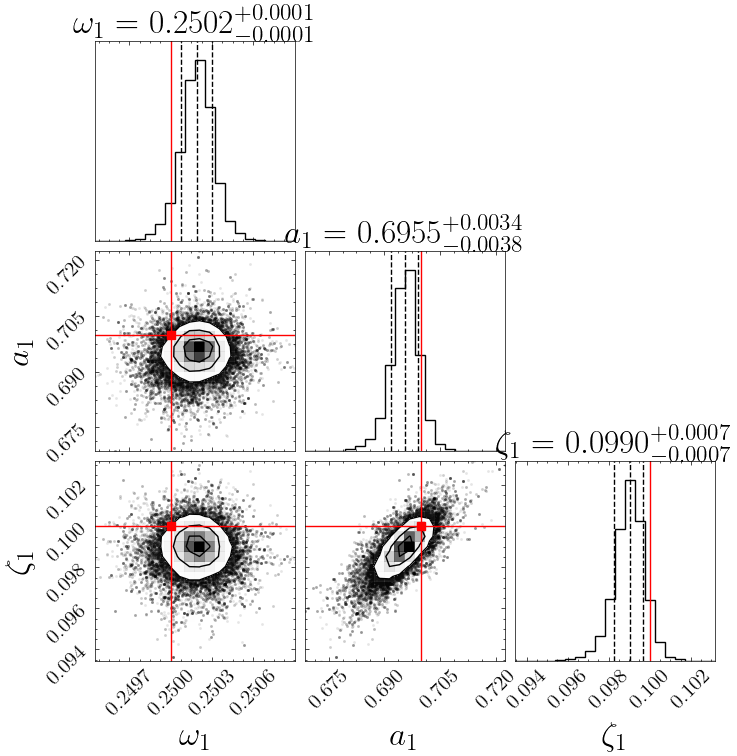

In [537]:
s.plot_corner(mode_num=1, truths=theta, figsize=(10,10))

### Changing Prior

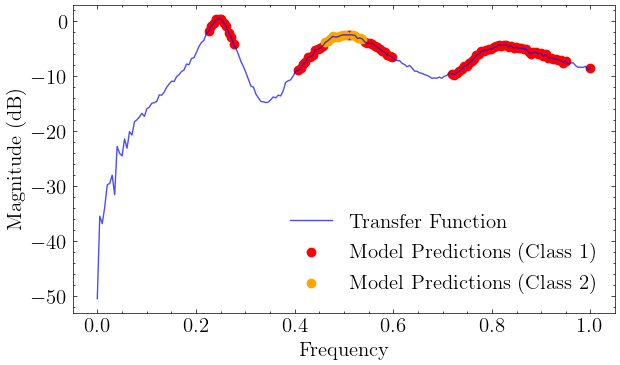

[ 0.21482412  0.38668342  0.68266332 -0.60106342  0.36256917  0.42731279
  0.06666667  0.12666667  0.09236948 -5.        ]
[ 0.29020101  0.62788945  0.99723618  0.60106342  2.51942546  2.36736613
  0.15        0.285       0.20783133 -1.        ]


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 852.24it/s]

(1000, 200, 10)


In [538]:
s_normal = Sampler(model,tf, w=None)
s_normal.run_sampler(nwalkers=200, nsteps=1000, sampler="emcee", prior="normal", return_results=True, phase=False, max_opt_its=1000, multi_output=False)

In [403]:
s.burn_in(1000)

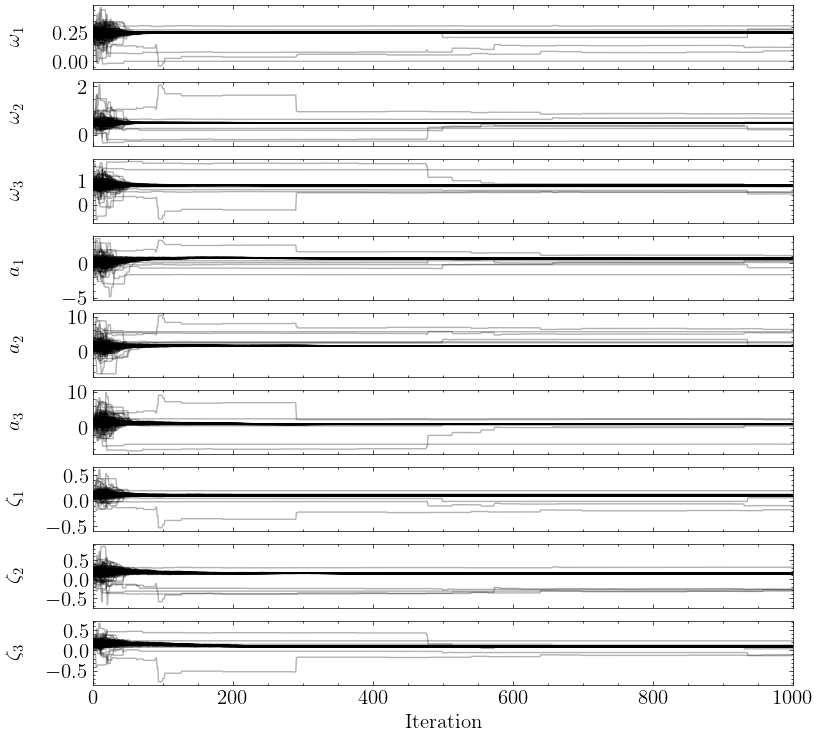

In [541]:
s_normal.plot_state_evolution()

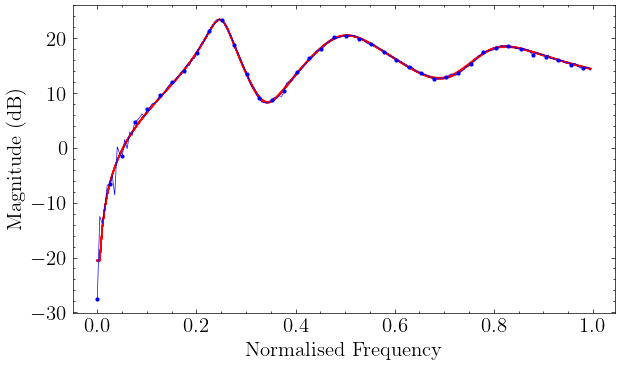

In [540]:
s.plot_posterior_samples()

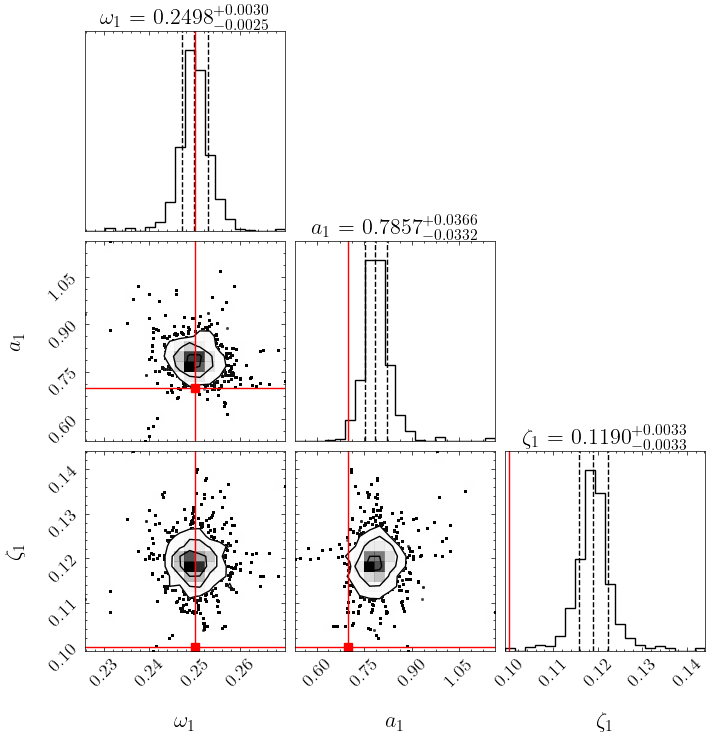

In [260]:
s.plot_corner(mode_num=1, truths=theta, tight=False, lpad=-30)

In [74]:
samples = s.get_samples()

### Number of walkers

In [299]:
X, Y, ws, zs, a_s = generate_dat_extended(100, 200, sigma_max=0.15, max_modes=5, multiclass=True, normalise=None, neg_an=True, logmag=False, scaled_logmag=False, a_max=2.0, method=1, norm_95=True, w_n=[0.13, 0.37, 0.65, 0.95])

In [510]:
print(idx2)

76


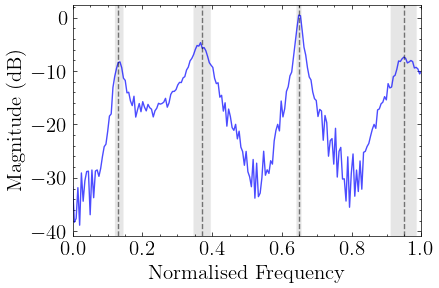

(<Figure size 450x300 with 1 Axes>,
 <Axes: xlabel='Normalised Frequency', ylabel='Magnitude (dB)'>)

In [321]:
idx2 = np.random.randint(0, len(X))
plot_tf(X[idx2,:,:2], Y[idx2], ws=ws[idx2], figsize=(4.5, 3))

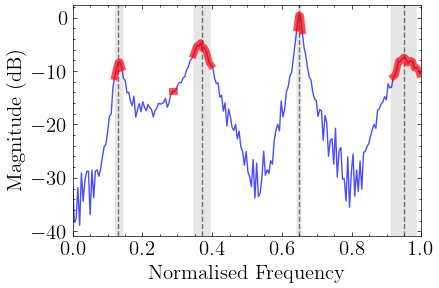

(<Figure size 450x300 with 1 Axes>,
 <Axes: xlabel='Normalised Frequency', ylabel='Magnitude (dB)'>)

In [322]:
plot_tf(X[idx2,:,:2], Y[idx2], ws=ws[idx2], figsize=(4.5, 3), model=model, X=X[idx2])

In [323]:
tf2 = X[idx2,:,0] + 1j*X[idx2,:,1]

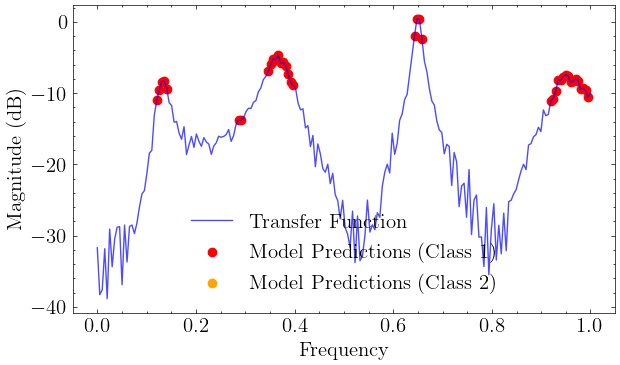

[ 1.14572864e-01  2.72110553e-01  3.29396985e-01  6.11055276e-01
  8.78391960e-01 -1.24931769e-02 -1.54972619e-03 -4.68633530e-02
 -2.40789397e-02 -5.01066256e-02  5.12820513e-02  5.79710145e-03
  4.50450450e-02  7.72200772e-03  2.61096606e-02 -5.00000000e+00]
[ 0.14773869  0.30603015  0.41683417  0.69120603  1.05        0.01249318
  0.00154973  0.04686335  0.02407894  0.05010663  0.11538462  0.01304348
  0.10135135  0.01737452  0.05874674 -1.        ]
Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 12
Iter. Eval.  Best      Current   Time m:s
0     12     -1455.756 -1455.756   0:00.0
1     24     -1357.107 -1357.107   0:00.0
2     36     -1307.866 -1307.866   0:00.0
3     48     -1260.544 -1260.544   0:00.0
20    252    -928.6347 -934.4755   0:00.0
40    492    -836.5444 -840.5194   0:00.1
60    732    -766.9271 -770.3745   0:00.1
80    972    -736.089  -736.089    0:00.1
100   1212   -717.5159 -718.2162   0

In [327]:
s1v2 = Sampler(model, tf2, w=None)
s1v2.run_sampler(nwalkers=50, nsteps=3000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, return_results=True, phase=False, max_opt_its=2000)

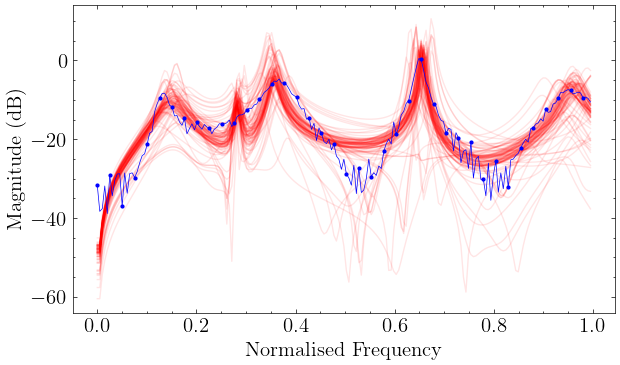

In [330]:
s1v2.plot_posterior_samples()

In [637]:
print(ws[idx2])

[0.22416762 0.38784479 0.77125548]


In [648]:
tf_test = modal.modal_sum_fast(np.linspace(0,1,200), a_s[idx2], zs[idx2], ws[idx2])

In [646]:
print(a_s[idx2])

[1.57507545 1.59786151 1.95557073]


In [644]:
mode = 1
truths_1 = [ws[idx2][mode-1], a_s[idx2][1], zs[idx2][1]]

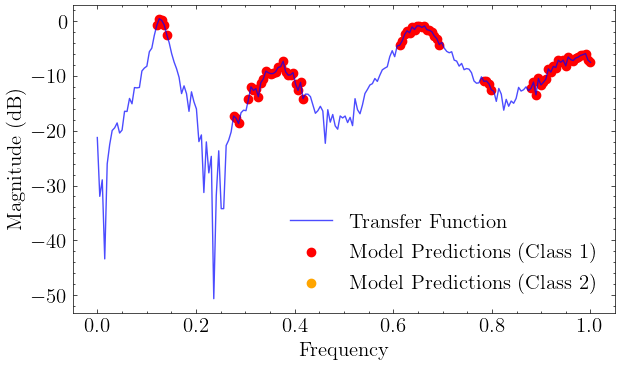

[ 1.14572864e-01  2.62562814e-01  2.91206030e-01  5.82412060e-01
  7.44723618e-01  8.40201005e-01 -3.41789921e-02 -2.09271852e-03
 -8.23177538e-02 -1.15896186e-01 -6.49212847e-03 -9.29517346e-02
  5.12820513e-02  1.19047619e-02  1.01851852e-01  4.10256410e-02
  6.34920635e-03  4.08888889e-02 -5.00000000e+00]
[ 0.14773869  0.30075377  0.4379397   0.7281407   0.83894472  1.05
  0.03417899  0.00209272  0.08231775  0.11589619  0.00649213  0.09295173
  0.11538462  0.02678571  0.22916667  0.09230769  0.01428571  0.092
 -1.        ]
Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 12
Iter. Eval.  Best      Current   Time m:s
0     12     -2548.71  -2548.71    0:00.0
1     24     -2374.689 -2374.689   0:00.0
2     36     -2271.312 -2271.312   0:00.0
3     48     -2192.829 -2192.829   0:00.0
20    252    -1691.548 -1732.55    0:00.0
40    492    -1431.775 -1431.775   0:00.1
60    732    -1379.391 -1379.391   0:00.1
80 

In [270]:
s1v2_200 = Sampler(model, tf2, w=None)
s1v2_200.run_sampler(nwalkers=200, nsteps=3000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, return_results=True, phase=False, max_opt_its=2000)

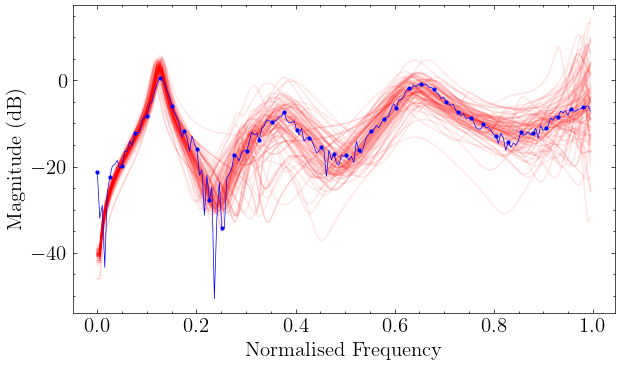

In [276]:
s1v2_200.plot_posterior_samples()

### Original Example

In [35]:
X, Y, ws, zs = generate_dat_extended(100, 200, sigma_max=0.15, max_modes=5, multiclass=True, normalise=None, neg_an=True, logmag=False, scaled_logmag=False, a_max=2.0, method=1, norm_95=True)

In [154]:
print(X.shape)

(4, 200, 4)


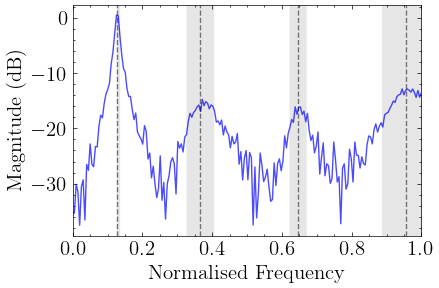

(<Figure size 450x300 with 1 Axes>,
 <Axes: xlabel='Normalised Frequency', ylabel='Magnitude (dB)'>)

In [149]:
idx = np.random.randint(0, len(X))
plot_tf(X[idx,:,:2], Y[idx], ws=ws[idx], figsize=(4.5, 3))

In [152]:
print(idx)

4


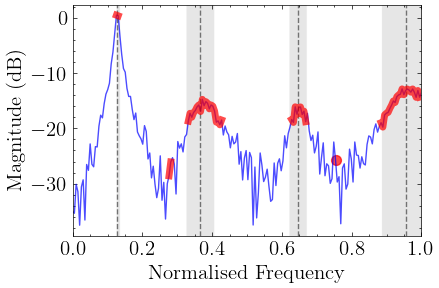

(<Figure size 450x300 with 1 Axes>,
 <Axes: xlabel='Normalised Frequency', ylabel='Magnitude (dB)'>)

In [160]:
plot_tf(X[idx,:,:2], Y[idx], ws=ws[idx], figsize=(4.5, 3), model=model, X=X[idx], name='example_noisy')

In [169]:
print(idx)

27


In [60]:
tf = X[idx,:,0] + 1j*X[idx,:,1]

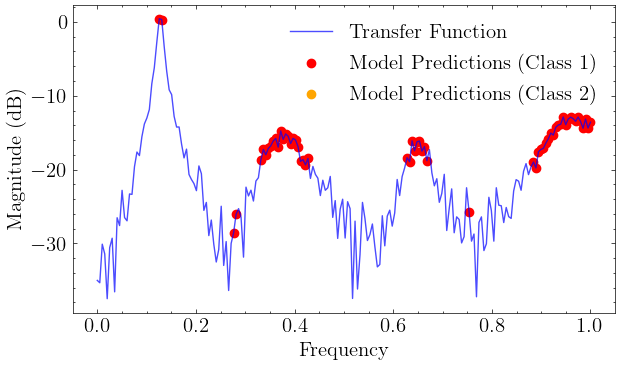

[ 1.19346734e-01  2.62562814e-01  3.15075377e-01  5.96733668e-01
  7.16080402e-01  8.44974874e-01 -8.08998553e-03 -3.78276437e-04
 -2.94646167e-02 -9.73163030e-03 -6.26044245e-02 -3.98839161e-02
  1.30718954e-02  6.00600601e-03  8.38852097e-02  2.06718346e-02
  1.00000000e-04  3.90070922e-02 -5.00000000e+00]
[ 1.37185930e-01  2.95477387e-01  4.48492462e-01  7.01758794e-01
  7.91457286e-01  1.05000000e+00  8.08998553e-03  3.78276437e-04
  2.94646167e-02  9.73163030e-03  6.26044245e-02  3.98839161e-02
  2.94117647e-02  1.35135135e-02  1.88741722e-01  4.65116279e-02
  8.00000000e-01  8.77659574e-02 -1.00000000e+00]


100%|██████████| 3000/3000 [00:01<00:00, 2855.95it/s]

(3000, 50, 19)


In [393]:
s1v2 = Sampler(model, tf, w=None)
s1v2.run_sampler(nwalkers=50, nsteps=3000, sampler="emcee", pints_sampler = pints.EmceeHammerMCMC, return_results=True, phase=False, max_opt_its=2000)

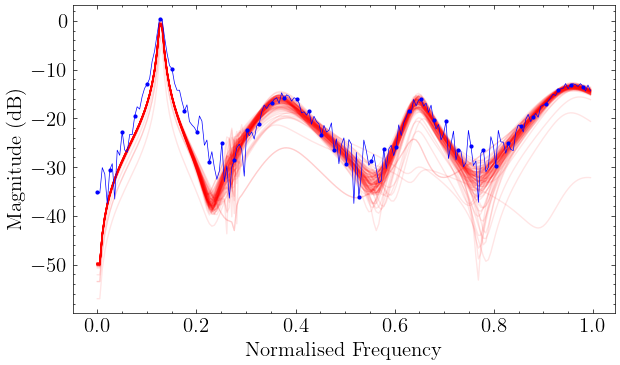

In [403]:
s1v2.plot_posterior_samples()

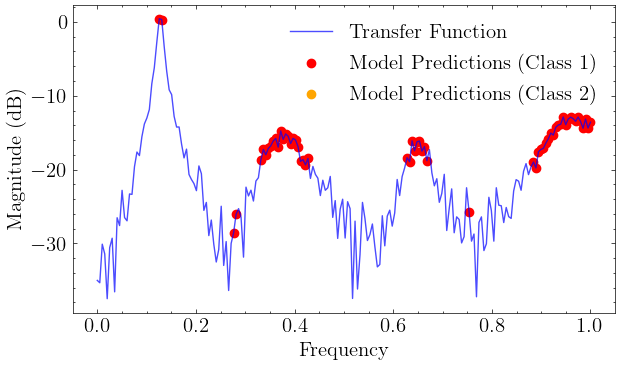

[ 1.19346734e-01  2.62562814e-01  3.15075377e-01  5.96733668e-01
  7.16080402e-01  8.44974874e-01 -8.08998553e-03 -3.78276437e-04
 -2.94646167e-02 -9.73163030e-03 -6.26044245e-02 -3.98839161e-02
  1.30718954e-02  6.00600601e-03  8.38852097e-02  2.06718346e-02
  1.00000000e-04  3.90070922e-02 -5.00000000e+00]
[ 1.37185930e-01  2.95477387e-01  4.48492462e-01  7.01758794e-01
  7.91457286e-01  1.05000000e+00  8.08998553e-03  3.78276437e-04
  2.94646167e-02  9.73163030e-03  6.26044245e-02  3.98839161e-02
  2.94117647e-02  1.35135135e-02  1.88741722e-01  4.65116279e-02
  8.00000000e-01  8.77659574e-02 -1.00000000e+00]
Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 12
Iter. Eval.  Best      Current   Time m:s
0     12     -2798.6   -2798.6     0:00.0
1     24     -2740.109 -2740.109   0:00.0
2     36     -2581.315 -2581.315   0:00.0
3     48     -2548.72  -2548.72    0:00.0
20    252    -1091.974 -1091.974   0:00.0

In [222]:
s1 = Sampler(model, tf, w=None)
s1.run_sampler(nwalkers=50, nsteps=3000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, return_results=True, phase=False, max_opt_its=2000)

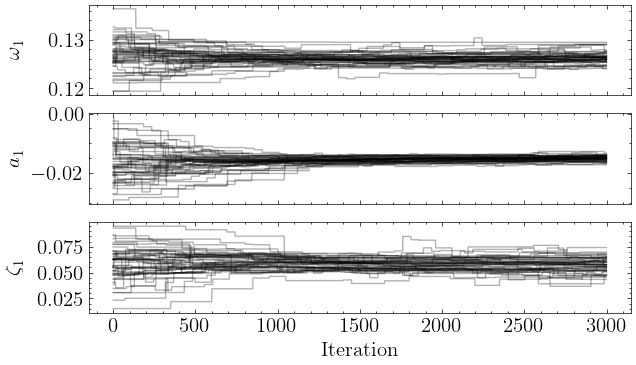

In [223]:
s1.plot_state_evolution(mode_num=1, figsize=(7,4),ypos=-0.12, name='example_noisy_trace_50')

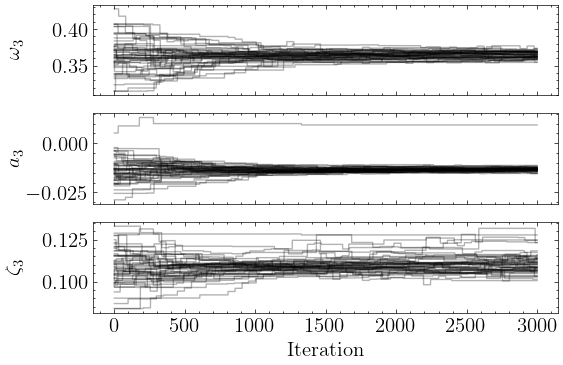

In [656]:
s1.plot_state_evolution(mode_num=3, figsize=(6,4),ypos=-0.15, name='example_noisy_trace_50')

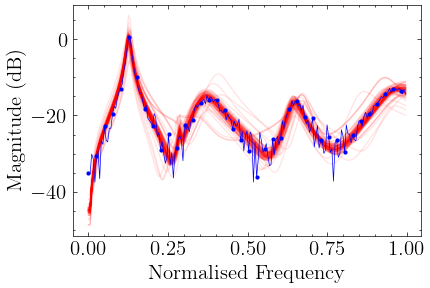

In [229]:
s1.plot_posterior_samples(figsize=(4.5,3), name='example_noisy_samples_50')

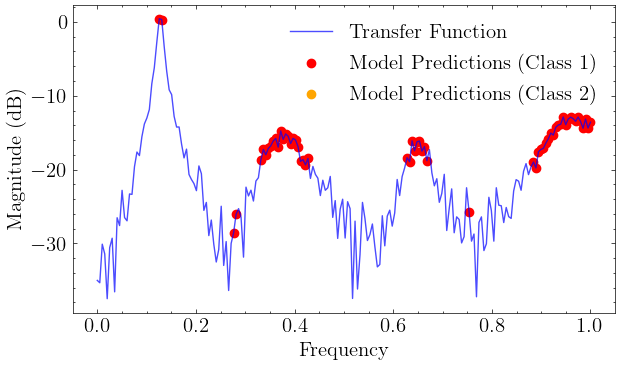

[ 1.19346734e-01  2.62562814e-01  3.15075377e-01  5.96733668e-01
  7.16080402e-01  8.44974874e-01 -8.08998553e-03 -3.78276437e-04
 -2.94646167e-02 -9.73163030e-03 -6.26044245e-02 -3.98839161e-02
  1.30718954e-02  6.00600601e-03  8.38852097e-02  2.06718346e-02
  1.00000000e-04  3.90070922e-02 -5.00000000e+00]
[ 1.37185930e-01  2.95477387e-01  4.48492462e-01  7.01758794e-01
  7.91457286e-01  1.05000000e+00  8.08998553e-03  3.78276437e-04
  2.94646167e-02  9.73163030e-03  6.26044245e-02  3.98839161e-02
  2.94117647e-02  1.35135135e-02  1.88741722e-01  4.65116279e-02
  8.00000000e-01  8.77659574e-02 -1.00000000e+00]
Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 12
Iter. Eval.  Best      Current   Time m:s
0     12     -1068.589 -1068.589   0:00.0
1     24     -1040.753 -1040.753   0:00.0
2     36     -1030.847 -1030.847   0:00.0
3     48     -1023.821 -1023.821   0:00.0
20    252    -657.5103 -657.5103   0:00.2

In [413]:
s1_200 = Sampler(model, tf, w=None)
s1_200.run_sampler(nwalkers=200, nsteps=5000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, return_results=True, phase=False, max_opt_its=2000)

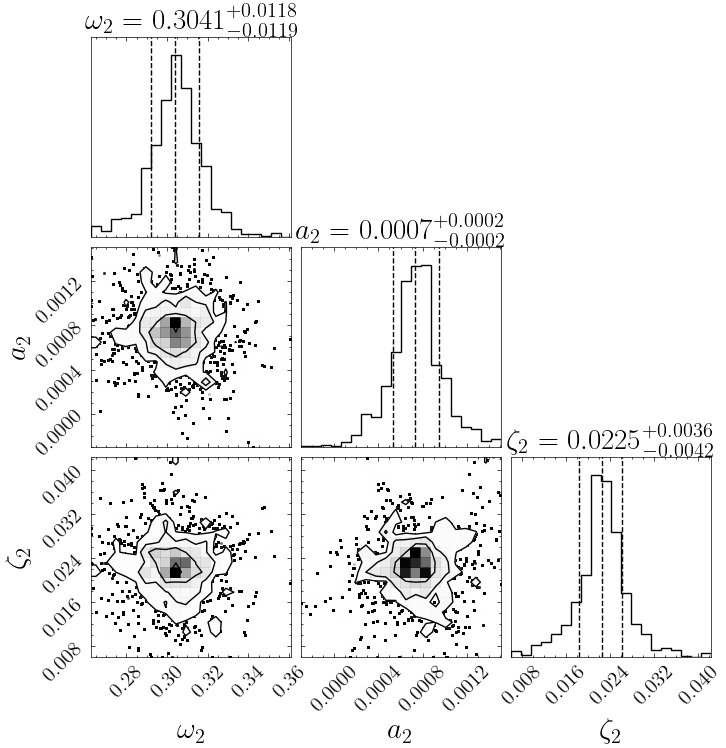

In [416]:
s1_200.plot_corner(mode_num=2)

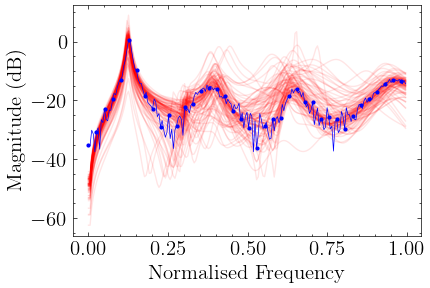

In [422]:
s1_200.plot_posterior_samples(figsize=(4.5,3), name='example_noisy_samples_200')

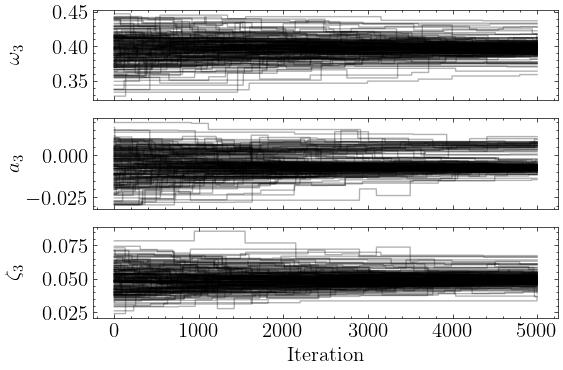

In [659]:
s1_200.plot_state_evolution(mode_num=3, figsize=(6,4),ypos=-0.15, name='example_noisy_trace_200')

### Noise removal

In [3]:
s1_long = Sampler(model, tf, w=None)
s1_long.run_sampler(nwalkers=50, nsteps=7000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, return_results=True, phase=False, max_opt_its=2000)

NameError: name 'Sampler' is not defined

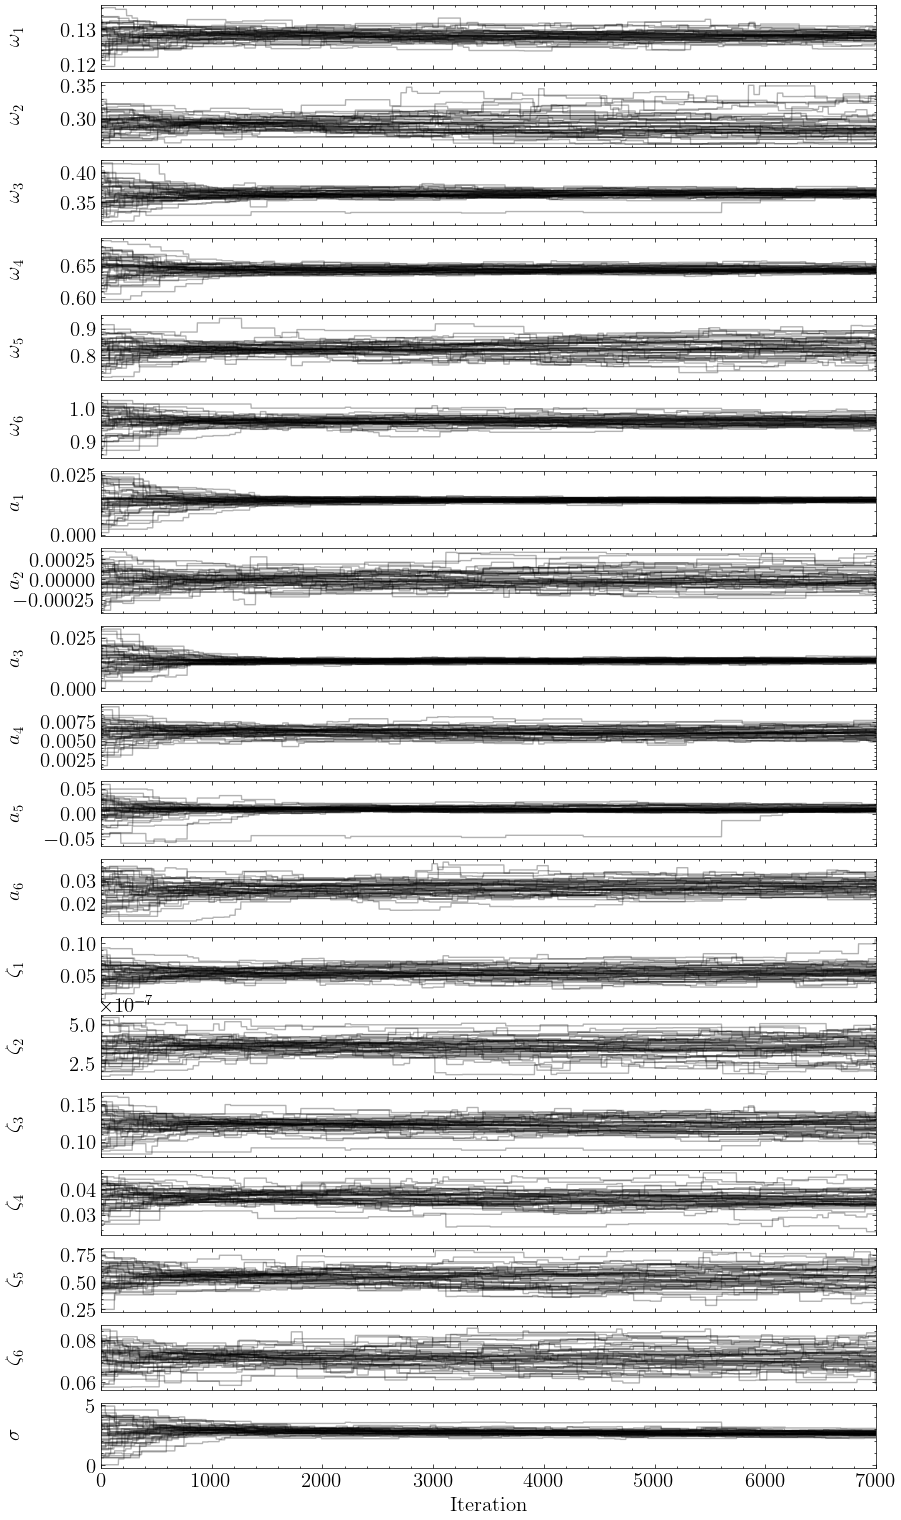

In [702]:
s1_long.plot_state_evolution()

In [707]:
s1_long.burn_in(1000)

In [14]:
s1_long.plot_posterior_samples(figsize=(4.5,3), name='noise_removal_samples')

NameError: name 's1_long' is not defined

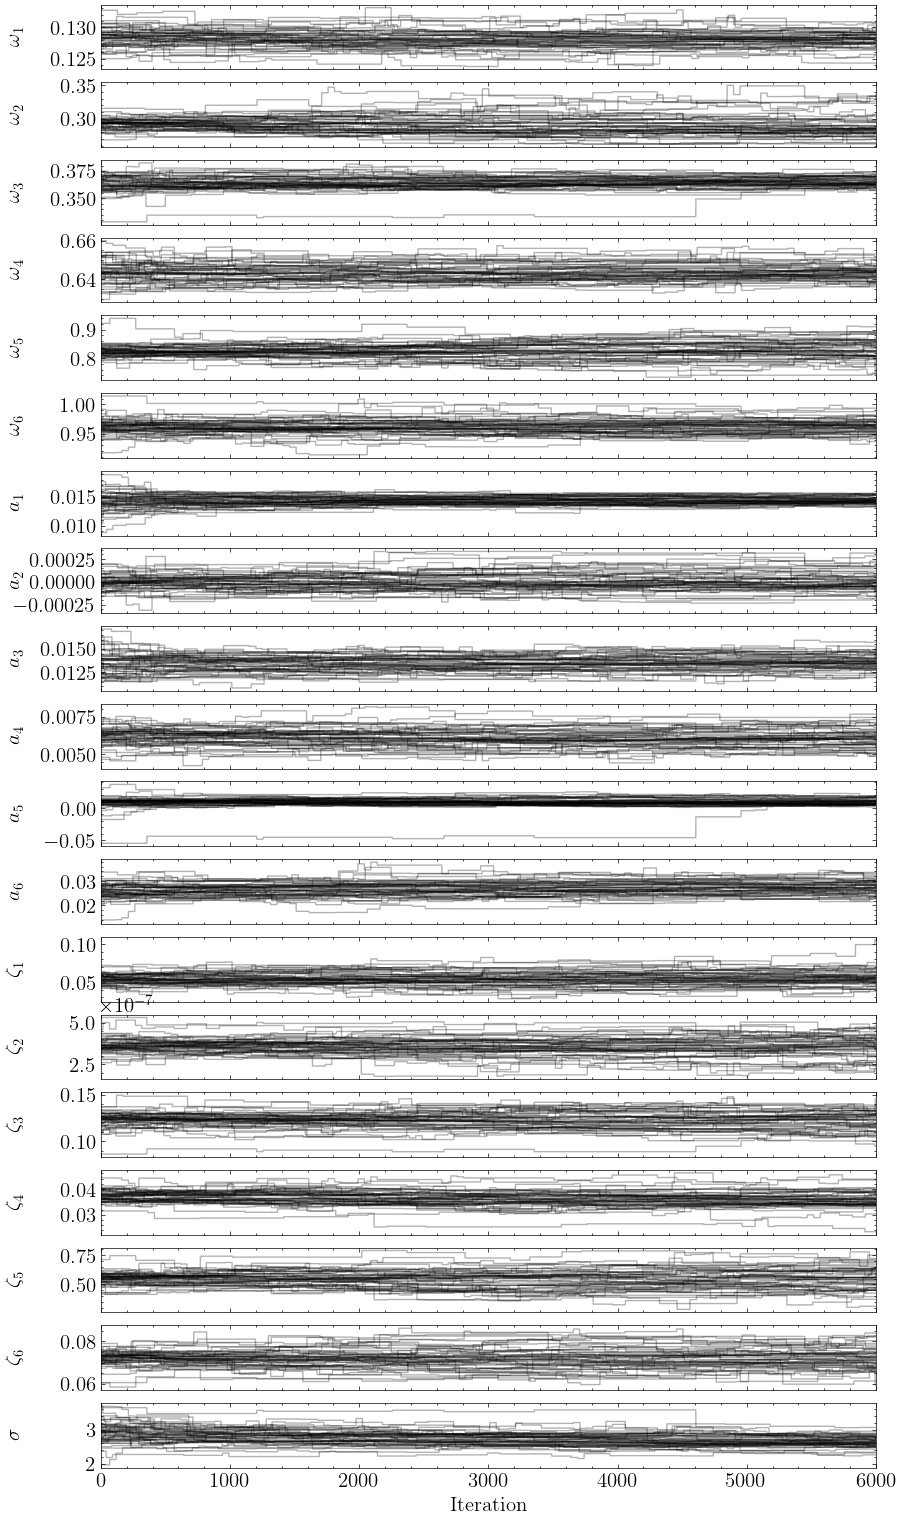

In [712]:
s1_long.plot_state_evolution()

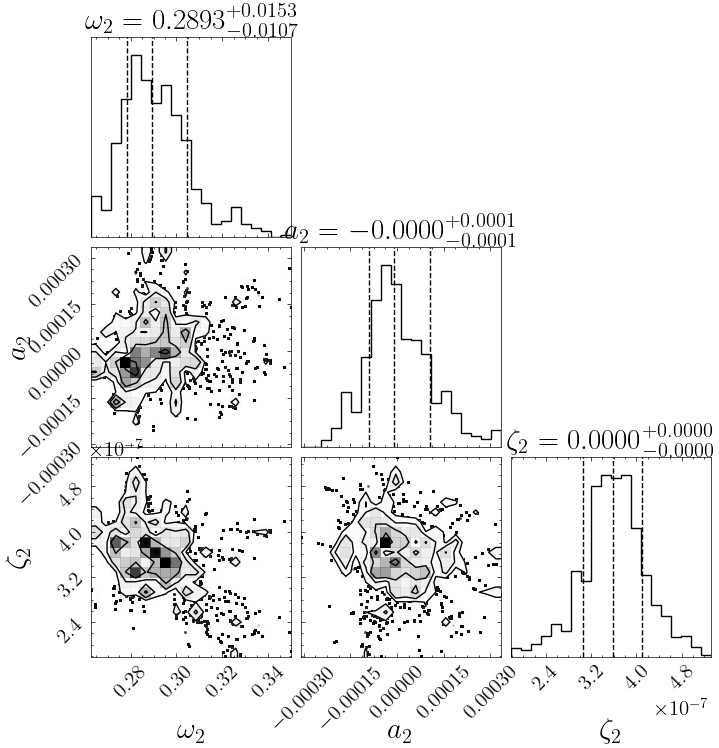

In [713]:
s1_long.plot_corner(mode_num=2, name='noise')

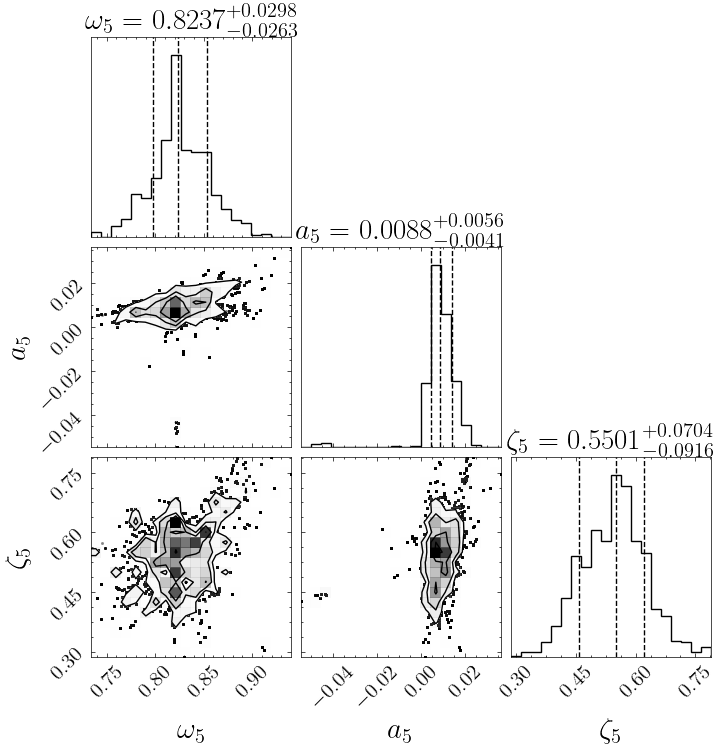

In [714]:
s1_long.plot_corner(mode_num=5, name='noise')

### 3C6

In [39]:
tf_3c6, w_3c6 = sampler.load_sampling_data(cutoff=3000)

2024-05-27 04:51:43.186 python[38894:74628212] +[CATransaction synchronize] called within transaction


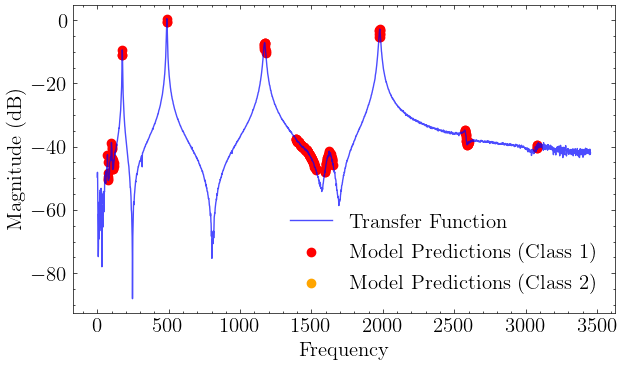

[ 6.78422758e+01  9.41038019e+01  1.65228769e+02  4.61765168e+02
  1.10736102e+03  1.32183015e+03  1.51332044e+03  1.87441643e+03
  2.44341616e+03  2.92268901e+03 -1.10598011e-01 -4.99205301e-01
 -1.93826377e+00 -6.02182885e+00 -1.51537612e+01 -4.71020856e+00
 -1.18478943e+00 -1.85508925e+01 -1.31282375e+00 -1.22799801e-01
  2.58397933e-02  5.01792115e-02  4.38596491e-03  1.57604413e-03
  3.92927308e-03  3.15457413e-02  1.13717129e-02  1.74672489e-03
  3.71112596e-03  4.98815314e-04 -5.00000000e+00]
[ 8.10306299e+01  1.20941239e+02  1.85040095e+02  5.12790852e+02
  1.23843828e+03  1.60609965e+03  1.73066913e+03  2.08260813e+03
  2.73085317e+03  3.23517814e+03  1.10598011e-01  4.99205301e-01
  1.93826377e+00 -2.38567471e+00 -4.57622227e+00 -6.25920361e-01
  1.18478943e+00 -6.13600381e+00  1.31282375e+00  1.22799801e-01
  5.81395349e-02  1.12903226e-01  9.86842105e-03  3.54609929e-03
  8.84086444e-03  7.09779180e-02  2.55863539e-02  3.93013100e-03
  8.35003340e-03  1.12233446e-03 -1.0000

In [40]:
s = Sampler(model, tf_3c6, w_3c6)
s.run_sampler(nwalkers=100, nsteps=10000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, return_results=True, phase=False, max_opt_its=8000)

In [29]:
s.burn_in(3000)

In [30]:
s.plot_posterior_samples(markevery=90, figsize=(6,4), name='final_3c6_burned_zoomed', zoomed=True, xlims=[2300, 3400], ylims=[-42, -27])

<IPython.core.display.Javascript object>

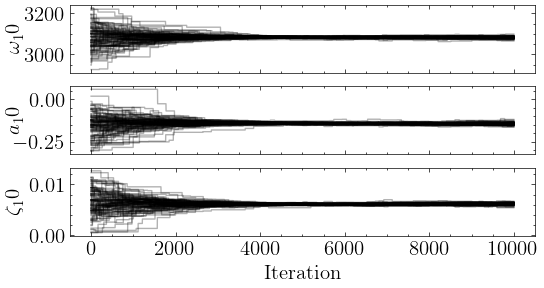

In [19]:
s.plot_state_evolution(mode_num=10)

<Figure size 600x600 with 0 Axes>

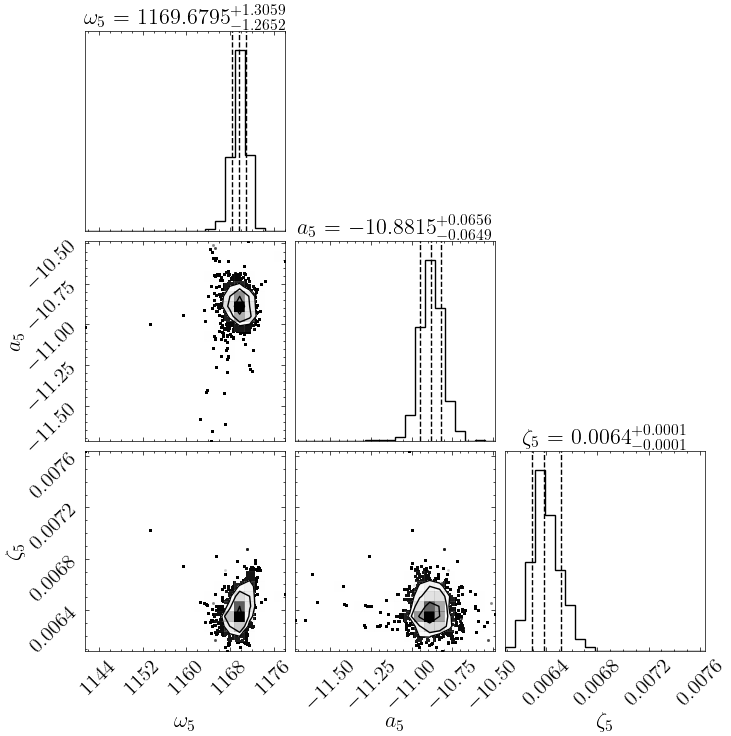

<Figure size 600x600 with 0 Axes>

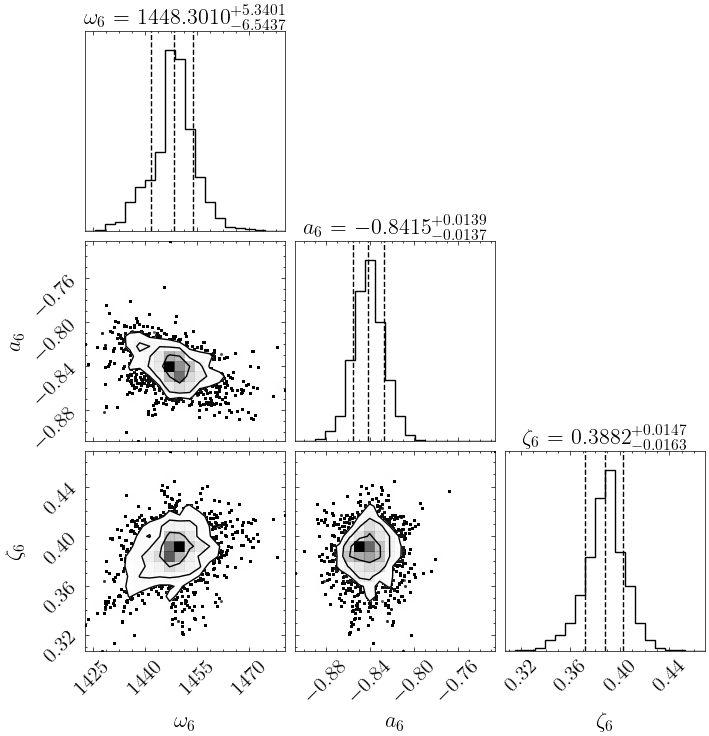

In [39]:
s.plot_corner(mode_num=[5,6], name='3c6')  

In [20]:
s_phase = Sampler(model, tf_3c6, w_3c6)
s_phase.run_sampler(nwalkers=100, nsteps=10000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, return_results=True, phase=True, max_opt_its=8000)

<IPython.core.display.Javascript object>

[ 6.78422758e+01  9.41038019e+01  1.65228769e+02  4.61765168e+02
  1.10736102e+03  1.32183015e+03  1.51332044e+03  1.87441643e+03
  2.44341616e+03  2.92268901e+03 -1.10598011e-01 -4.99205301e-01
 -1.93826377e+00 -6.02182885e+00 -1.51537612e+01 -4.71020856e+00
 -1.18478943e+00 -1.85508925e+01 -1.31282375e+00 -1.22799801e-01
  2.58397933e-02  5.01792115e-02  4.38596491e-03  1.57604413e-03
  3.92927308e-03  3.15457413e-02  1.13717129e-02  1.74672489e-03
  3.71112596e-03  4.98815314e-04 -7.85398163e-01 -7.85398163e-01
 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -5.00000000e+00]
[ 8.10306299e+01  1.20941239e+02  1.85040095e+02  5.12790852e+02
  1.23843828e+03  1.60609965e+03  1.73066913e+03  2.08260813e+03
  2.73085317e+03  3.23517814e+03  1.10598011e-01  4.99205301e-01
  1.93826377e+00 -2.38567471e+00 -4.57622227e+00 -6.25920361e-01
  1.18478943e+00 -6.13600381e+00  1.31282375e+00  1.22799801e-01
  5.813

In [23]:
s_phase.burn_in(3000)

In [24]:
s_phase.plot_posterior_samples(markevery=90, figsize=(6,4), name='final_3c6_phase_burned_zoomed', zoomed=True, xlims=[2300, 3400], ylims=[-42, -27]) 

<IPython.core.display.Javascript object>

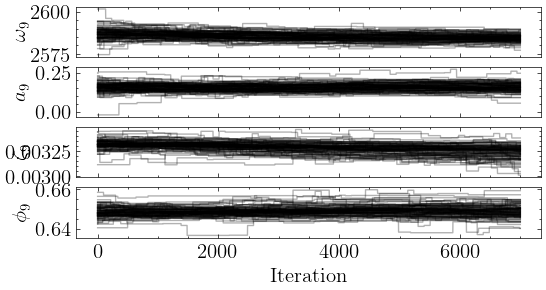

In [40]:
s_phase.plot_state_evolution(mode_num=9)

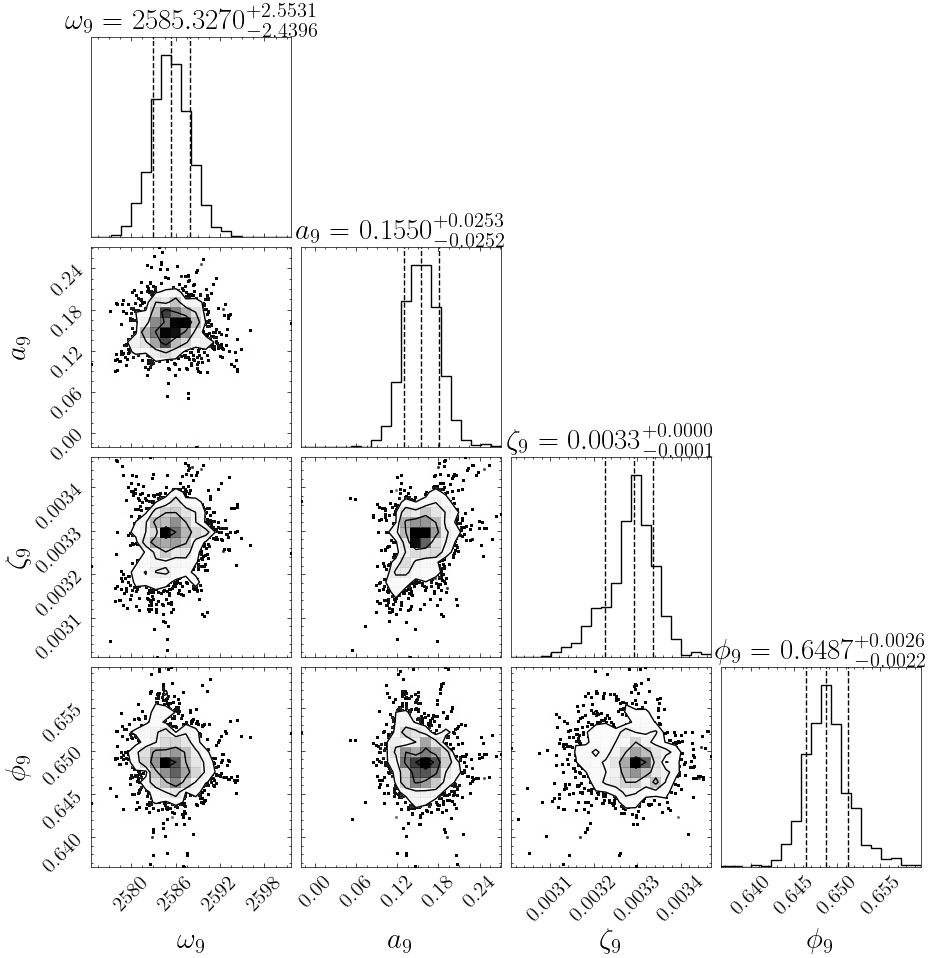

In [43]:
s_phase.plot_corner(mode_num=9, name='3c6_phase')

In [23]:
s_phase.burn_in(3000)

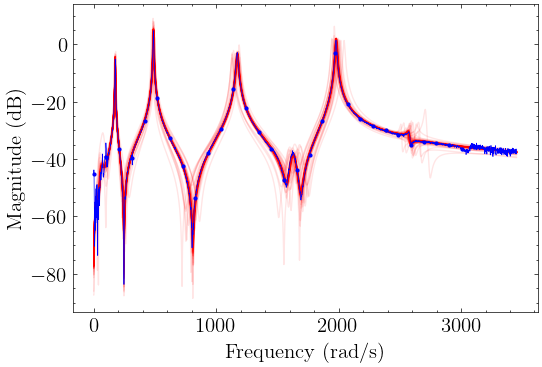

In [51]:
s_phase.plot_posterior_samples(markevery=90, figsize=(6,4)) 

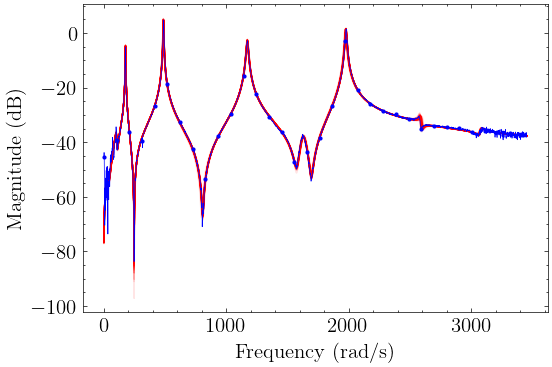

In [45]:
s_phase.plot_posterior_samples(markevery=90, figsize=(6,4), name='final_3c6_phase_burned') 

### 3C6 Noisy

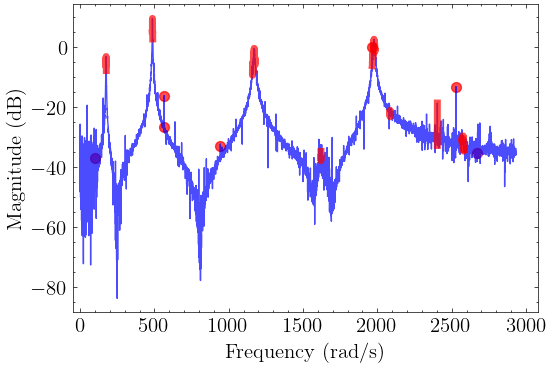

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='Frequency (rad/s)', ylabel='Magnitude (dB)'>)

In [38]:
plot_tf(tf_3c6_noisy, y=None, w=w_3c6_noisy, model=model, X=lab.extend_lab_tf(tf_3c6_noisy, max_norm=True), figsize=(6,4), name='noisy_3c6_predictions')

In [37]:
tf_3c6_noisy, w_3c6_noisy = sampler.load_sampling_data(cutoff=14000)

2024-05-27 04:23:21.200 python[38894:74628212] +[CATransaction synchronize] called within transaction


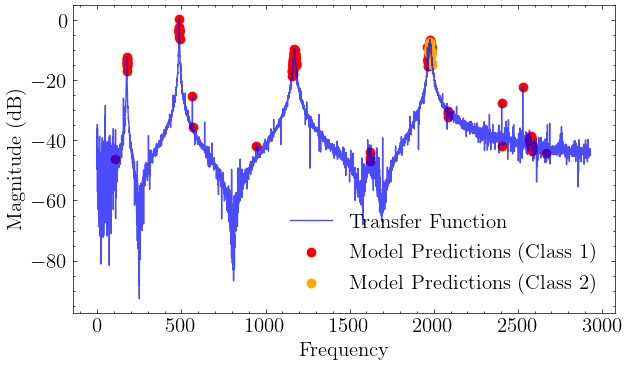

[ 9.74930088e+01  1.65141219e+02  4.61400586e+02  5.37206375e+02
  5.38400167e+02  8.96537750e+02  1.10167100e+03  1.53919575e+03
  1.86450405e+03  1.86788646e+03  1.89136437e+03  1.98109773e+03
  2.28332606e+03  2.40270525e+03  2.44170246e+03  2.44329418e+03
  2.45503313e+03  2.53680788e+03 -2.29022771e+00 -2.60930607e+00
 -1.39999255e+01  1.74308865e-02  5.30307899e-03  4.23871500e-03
 -2.00000000e+01 -1.14281053e-02  3.89006547e-01 -2.00000000e+01
 -2.00000000e+01 -8.25858836e-02 -2.00000000e+01  1.09756519e-01
 -3.80492968e-02 -5.40899871e-01 -2.00000000e+01 -2.00000000e+01
  1.00000000e-04  4.78468900e-03  2.14915109e-03  1.00000000e-04
  1.00000000e-04  1.00000000e-04  5.55207307e-03  1.00000000e-04
  1.00000000e-04  3.39126749e-03  1.00000000e-04  1.00416729e-04
  1.00000000e-04  1.00000000e-04  1.08630710e-04  1.40852701e-03
  1.00000000e-04  1.00000000e-04 -7.85398163e-01 -7.85398163e-01
 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01 -7.85398163e-01
 -7.85398163e-01 -7.85398

In [18]:
s_noisy = Sampler(model, tf_3c6_noisy, w_3c6_noisy) #4.36
s_noisy.run_sampler(nwalkers=100, nsteps=10000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, return_results=True, phase=True, max_opt_its=6000)

In [75]:
s_noisy.burn_in(3000)

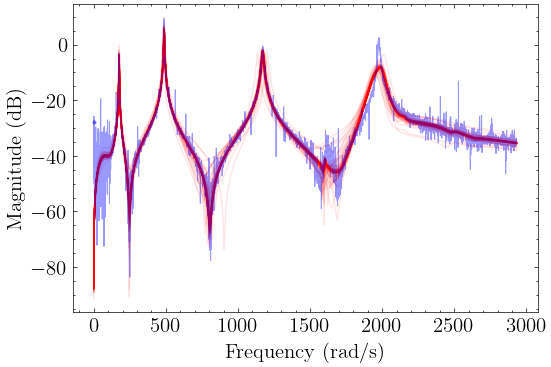

In [19]:
s_noisy.plot_posterior_samples(markevery=100000, tf_alpha=0.4, figsize=(6,4) ) #, name='final_3c6_noisy_burned'

In [20]:
tf_3c6_noisy2, w_3c6_noisy2 = sampler.load_sampling_data()

2024-05-27 03:02:18.137 python[34291:74553146] +[CATransaction synchronize] called within transaction


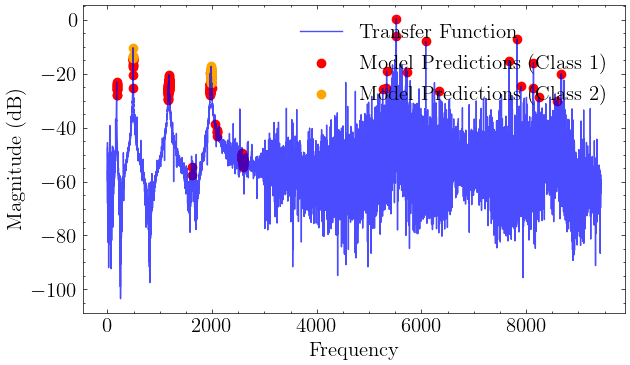

[ 1.65141219e+02  4.59211968e+02  4.61201621e+02  4.70950922e+02
  1.09868652e+03  1.10186996e+03  1.53939471e+03  1.86350922e+03
  1.86649370e+03  1.89116540e+03  1.94926328e+03  1.98089877e+03
  2.44607969e+03  2.45503313e+03  4.99582032e+03  5.06486129e+03
  5.06764680e+03  5.23557354e+03  5.24452698e+03  5.44349230e+03
  5.77735611e+03  6.02626173e+03  7.29207912e+03  7.43632898e+03
  7.50139065e+03  7.72681836e+03  7.73378214e+03  7.83485653e+03
  8.16195552e+03  8.23557269e+03 -2.82841379e+00  9.00367817e-02
 -1.58733802e+01  5.30872954e-02 -1.03171500e-01 -2.00000000e+01
 -2.00000000e+01  7.09090076e-01 -2.00000000e+01 -2.00000000e+01
 -2.00000000e+01 -1.10120040e-01 -4.26288048e-01 -2.43021956e-02
  5.42180330e-01 -2.00000000e+01 -2.00000000e+01  5.47139949e+00
 -2.00000000e+01 -2.00000000e+01  4.72003181e+00  6.01994812e-01
  2.60274396e+00 -2.00000000e+01 -2.00000000e+01 -2.00000000e+01
 -2.00000000e+01  5.84940887e-01  5.21871827e-01 -2.00000000e+01
  5.18031480e-03  1.00000

In [33]:
s_noisy2 = Sampler(model, tf_3c6_noisy2, w_3c6_noisy2)
s_noisy2.run_sampler(nwalkers=100, nsteps=10000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, return_results=True, phase=False, max_opt_its=1000)

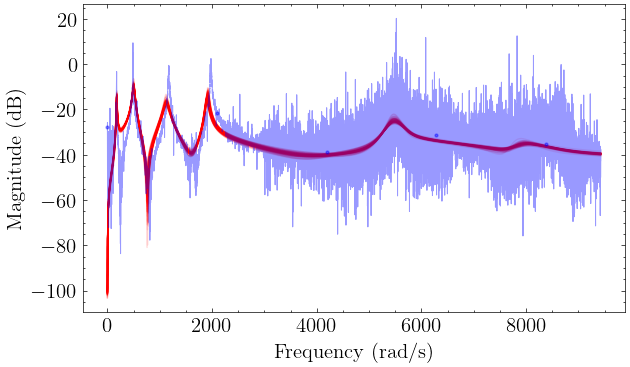

In [35]:
s_noisy2.plot_posterior_samples(tf_alpha=0.4, markevery=10000)

In [86]:
samples = s_noisy.get_samples()

In [87]:
print(samples.shape)

(7000, 100, 55)


In [88]:
flatsamples = samples.reshape(-1, samples.shape[-1])

In [96]:
num_modes = 3
total_modes = (samples.shape[-1]-1) // 3
figsize=(15,10)

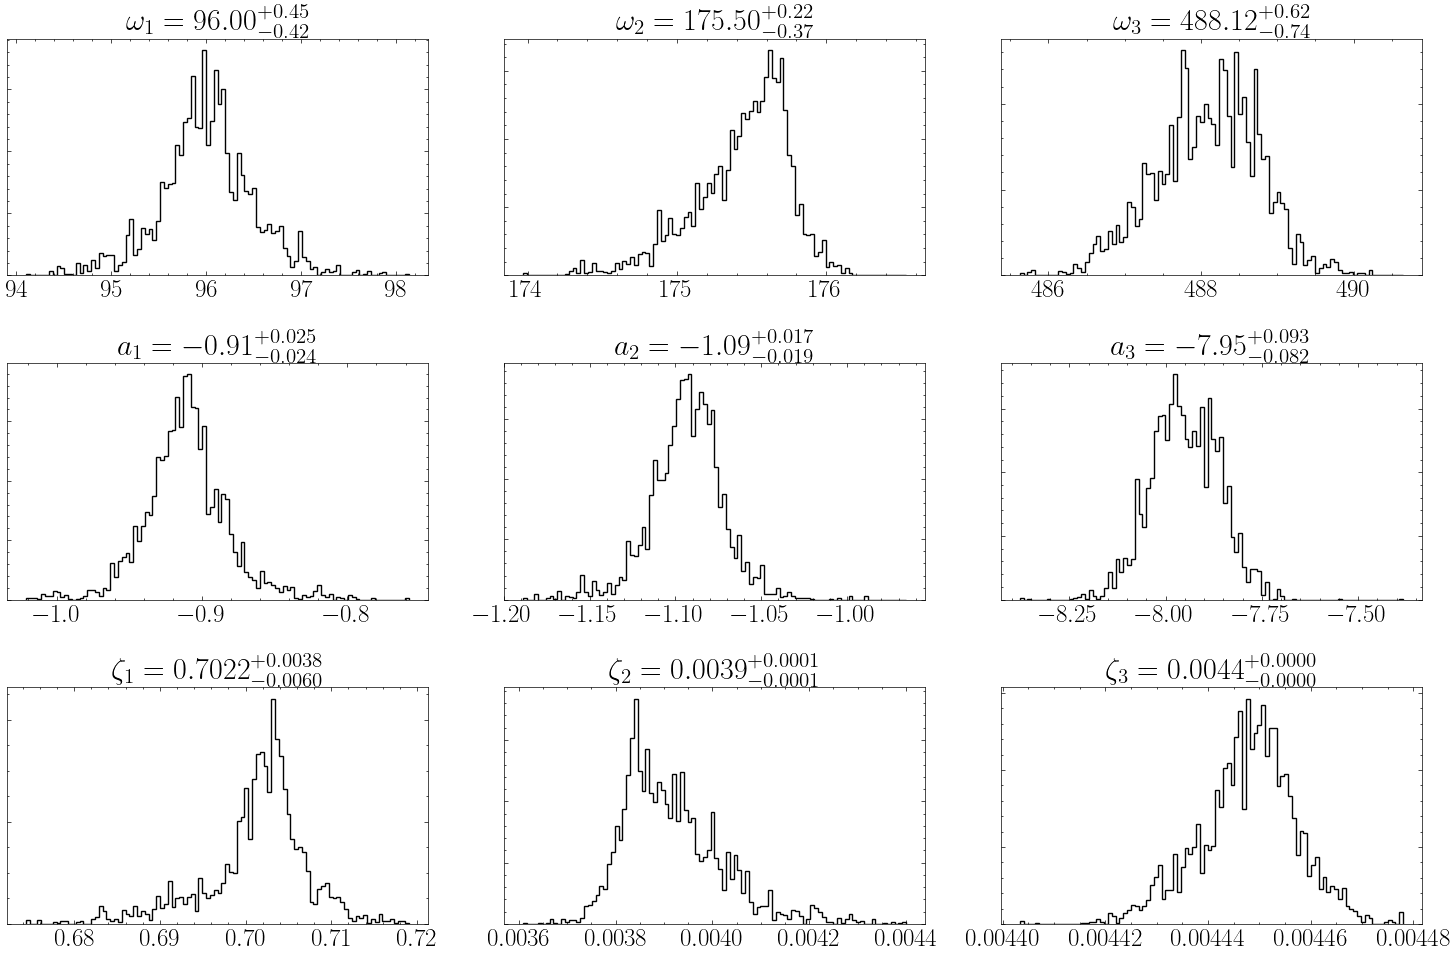

In [113]:
fig, axs = plt.subplots(num_modes, 3, figsize=figsize, tight_layout=True)
for i in range(num_modes):
    axs[0, i].hist(flatsamples[:, i], bins=100, color='k', histtype='step')
    axs[1, i].hist(flatsamples[:, i + total_modes], bins=100, color='k', histtype='step')
    axs[2, i].hist(flatsamples[:, i + 2*total_modes], bins=100, color='k', histtype='step')
    axs[0, i].yaxis.set_major_formatter(plt.NullFormatter()) 
    axs[1, i].yaxis.set_major_formatter(plt.NullFormatter()) 
    axs[2, i].yaxis.set_major_formatter(plt.NullFormatter())
    q1 = corner.quantile(flatsamples[:, i], [0.16, 0.5, 0.84])
    q2 = corner.quantile(flatsamples[:, i + total_modes], [0.16, 0.5, 0.84])
    q3 = corner.quantile(flatsamples[:, i + 2*total_modes], [0.16, 0.5, 0.84])
    axs[0, i].set_title(fr'$\omega_{i+1} = {q1[1]:.2f}^{{+{q1[2]-q1[1]:.2f}}}_{{-{q1[1]-q1[0]:.2f}}}$')
    axs[1, i].set_title(fr'$a_{i+1} = {q2[1]:.2f}^{{+{q2[2]-q2[1]:.3f}}}_{{-{q2[1]-q2[0]:.3f}}}$')
    axs[2, i].set_title(fr'$\zeta_{i+1} = {q3[1]:.4f}^{{+{q3[2]-q3[1]:.4f}}}_{{-{q3[1]-q3[0]:.4f}}}$')
plt.savefig('./Figs/3c6_noisy_marginals.pdf')
plt.show()

### 4C6

In [35]:
tf_dict, waxis_4c6 = sampler.load_sampling_data(cutoff = 2300, tf_type="acc", num_tfs=12)

2024-05-27 04:23:00.921 python[38894:74628212] +[CATransaction synchronize] called within transaction


In [11]:
print(waxis_4c6.shape)

(2300,)


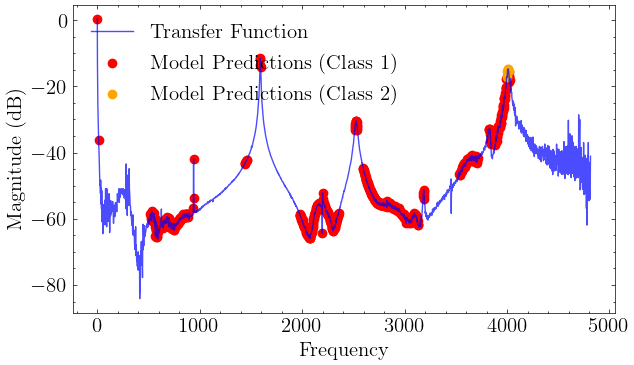

[ 6.63151432e-01  1.19367258e+01  4.93384666e+02  6.06783561e+02
  8.91275525e+02  1.36874456e+03  1.38068128e+03  1.38466019e+03
  1.50999581e+03  1.87605540e+03  2.38734516e+03  2.46493387e+03
  3.02198108e+03  3.35819885e+03  3.63274355e+03  3.69043772e+03
 -2.66755276e-01 -7.04008678e-02 -3.26337182e-02 -1.14974900e-01
 -1.14940228e-02 -1.00313361e-02 -3.92344997e+00 -5.52417010e-03
 -5.67680731e-01 -3.46541430e-01 -2.79565880e-01 -1.18538323e+00
 -1.17824095e-02 -5.67569563e-01 -1.46539513e-01  2.74570671e-01
  1.00000000e-04  1.00000000e-04  4.15879017e-02  1.07290234e-01
  1.48478099e-03  9.67585873e-04  1.00000000e-04  4.78583393e-04
  1.31492439e-03  5.86718246e-02  3.59165631e-03  6.26447288e-02
  1.31406045e-03  1.63729173e-02  1.63889648e-03  1.18259642e-02
 -5.00000000e+00]
[ 7.32956846e-01  1.31932232e+01  6.17882621e+02  9.27923367e+02
  9.89491742e+02  1.51722067e+03  1.52601615e+03  1.53261277e+03
  1.67553935e+03  2.47372936e+03  2.66722996e+03  3.28951033e+03
  3.353

In [15]:
s2 = Sampler(model, tf_dict['tf_4'], waxis_4c6)
s2.run_sampler(nwalkers=100, nsteps=10000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, max_opt_its=4000, return_results=True, phase=False)

In [23]:
s2.burn_in(3000)

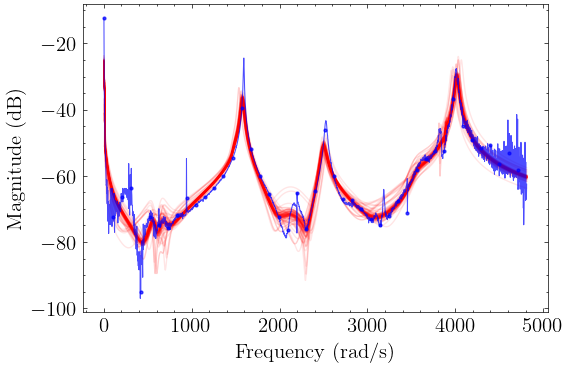

In [22]:
s2.plot_posterior_samples(tf_alpha=0.7, markevery=50, figsize=(6,4)) #, name='final_4c6'

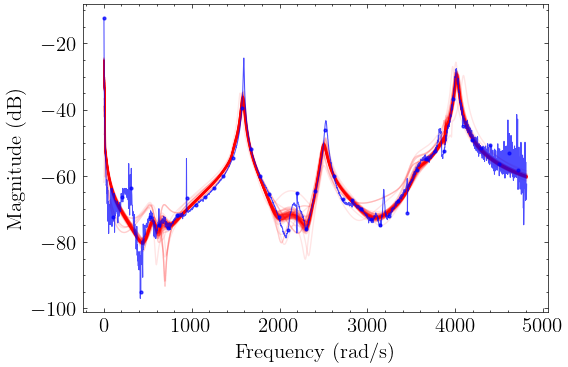

In [24]:
s2.plot_posterior_samples(tf_alpha=0.7, markevery=50, figsize=(6,4), name='final_4c6_burned')

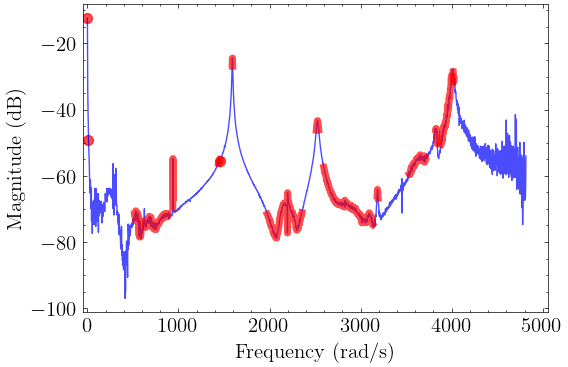

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='Frequency (rad/s)', ylabel='Magnitude (dB)'>)

In [36]:
plot_tf(tf_dict['tf_4'], y=None, w=waxis_4c6, model=model, X=lab.extend_lab_tf(tf_dict['tf_4'], max_norm=True), figsize=(6,4), name='4c6_predictions')

In [10]:
tf_dict_2, waxis_4c6_2 = sampler.load_sampling_data(cutoff=-1, tf_type="acc", num_tfs=12)

2024-05-27 03:48:53.145 python[38894:74628212] +[CATransaction synchronize] called within transaction


/Users/vaibhav/Documents/Engineering/Project/src/lab.py:72: RuntimeWarning: divide by zero encountered in divide
  phase = np.arctan(np.imag(tf_arr)/np.real(tf_arr))


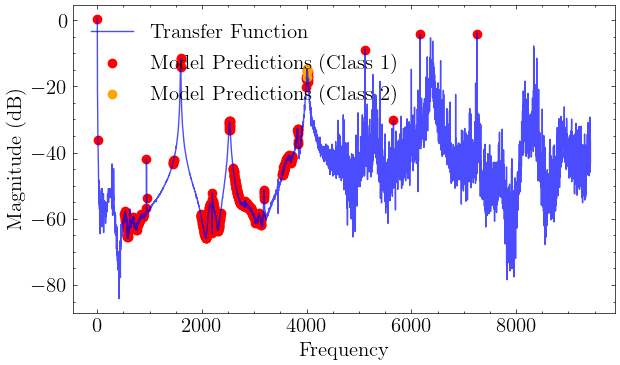

[ 6.63151432e-01  1.19367258e+01  4.93384666e+02  6.06783561e+02
  8.91275525e+02  1.36874456e+03  1.38068128e+03  1.38466019e+03
  1.50999581e+03  1.87605540e+03  2.38734516e+03  2.46493387e+03
  3.02198108e+03  3.35819885e+03  3.63274355e+03  3.79189989e+03
  4.85625794e+03  5.37550551e+03  5.85695345e+03  6.89146968e+03
 -2.66755276e-01 -7.04008678e-02 -3.26337182e-02 -1.14974900e-01
 -1.14940228e-02 -1.00313361e-02 -3.92344997e+00 -5.52417010e-03
 -5.67680731e-01 -3.46541430e-01 -2.79565880e-01 -1.18538323e+00
 -1.17824095e-02 -5.94931866e-01 -1.46539513e-01 -2.09185776e+00
 -2.00000000e+01  7.89678944e-03 -2.00000000e+01  2.06722600e-01
  1.00000000e-04  1.00000000e-04  4.15879017e-02  1.07290234e-01
  1.48478099e-03  9.67585873e-04  1.00000000e-04  4.78583393e-04
  1.31492439e-03  5.86718246e-02  3.59165631e-03  6.26447288e-02
  1.31406045e-03  1.71236171e-02  1.63889648e-03  2.78648555e-03
  1.00000000e-04  1.00000000e-04  1.00000000e-04  1.00000000e-04
 -5.00000000e+00]
[ 7.329

In [11]:
s3 = Sampler(model, tf_dict_2['tf_4'], waxis_4c6_2)
s3.run_sampler(nwalkers=100, nsteps=10000, sampler="pints", pints_sampler = pints.EmceeHammerMCMC, max_opt_its=8000, return_results=True, phase=False)

In [21]:
s3.burn_in(1000)

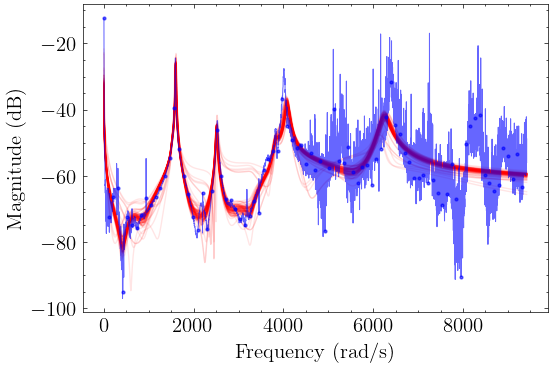

In [27]:
s3.plot_posterior_samples(tf_alpha=0.6, markevery=50, figsize=(6,4), name='final_4c6_full_burned')

/Users/vaibhav/Documents/Engineering/Project/src/lab.py:139: RuntimeWarning: divide by zero encountered in divide
  phase = np.arctan(np.imag(lab_tf)/np.real(lab_tf))


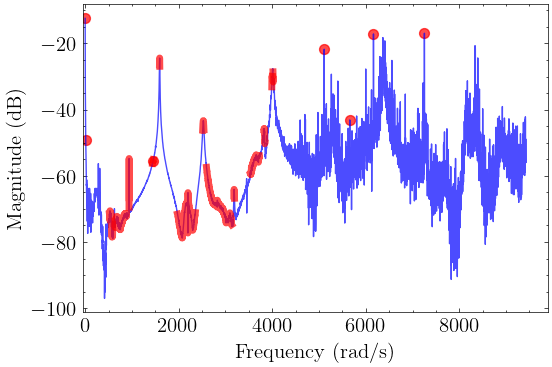

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='Frequency (rad/s)', ylabel='Magnitude (dB)'>)

In [33]:
plot_tf(tf_dict_2['tf_4'], y=None, w=waxis_4c6_2, model=model, X=lab.extend_lab_tf(tf_dict_2['tf_4'], max_norm=True), figsize=(6,4), name='4c6_predictions_full')

### Plotting stuff

In [10]:
%matplotlib notebook

In [5]:
import scienceplots

In [111]:
plt.style.use('science')
plt.rcParams.update({
    "font.size":18})  

In [11]:
plt.rcParams.update({
    "font.family":'serif'})  